<a href="https://colab.research.google.com/github/DeepCodeSec/ml1000-p3/blob/milestone3code/notebooks/group_1_project_with_ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 1 Project

## Business Case

### Authors

Jon Rasiko, Joel Ruetas, Samiha Simran, Amina Robi

### Abstract

Text classification is the process of assigning text documents into two or more categories. The most common form is binary classification or assigning one of two categories to all documents in the corpus. This project uses binary classification to assign websites as either benign or malicious.


### Background

Phishing is defined as “the practice of tricking Internet users (as through the use of deceptive email messages or websites) into revealing personal or confidential information which can then be used illicitly” (Definition of phishing, 2023). According to (Rosenthal, 2022), “96% of phishing attacks arrive by email. Another 3% are carried out through malicious websites and just 1% via phone”. The frequency and costs associated phishing and ransomware attacks have increased year after year:

* In 2020, 6.95 million new phishing and scam pages were created, with the highest number of new phishing and scam sites in one month of 206,310. The average ransom paid increased 171% from 2019 to 2020 (\$115,123 to \$312,493), said the 2021 Unit 42 Ransomware Threat Report.
* By September 2020, the average ransom payment peaked at $233,817, according to the 2021 Webroot BrightCloud Threat Report. The report also found that phishing spiked by 510 % from January to February 2020 alone.
* According to the Sift Q1 2021 Trust & Safety Index, in 2020 the pandemic increased online giving by 20.7%. This increase in traffic provided cover to fraudsters that hid behind transaction surges:
    * Ransomware attacks grew by over 40%.
    * Email malware attacks were up by 600% compared to 2019. 

Improving the detection and reporting of phishing emails/URLs is a critical requirement to reduce the success rate of social engineering attacks, which are the number 1 cause of compromise on corporate networks. Reducing the success rate of social engineering attacks also reduces any potential impact of costs associated with ransomware attacks and the legal and reputation costs associated with the disclosure of private data.

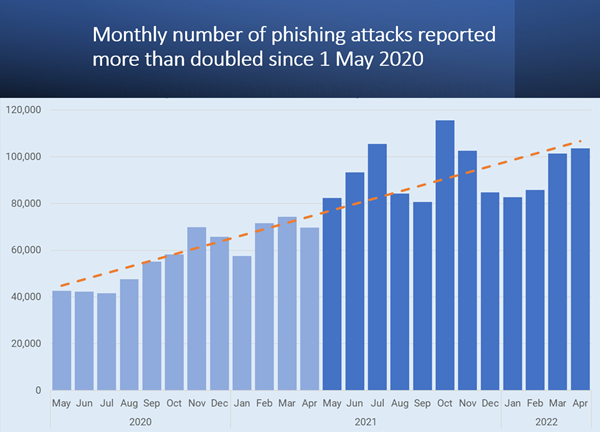

### Objective

The objective is to use text classification models to determine if
websites are benign or malicious. This will allow us to improve detection and reporting of phishing websites, so we are in better position reduce the
rate of social engineering attacks and leakage of private
data.

## Requirements

Before proceeding, you will be required to install some Python modules.

In [ ]:
%%capture
!pip install --upgrade pip
!pip install pycaret nltk

!pip3 install ydata-profiling --upgrade
from ydata_profiling import ProfileReport

!pip install yellowbrick

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import six
import sys
sys.modules['sklearn.externals.six'] = six

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, StackingClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score, log_loss
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix, PrecisionRecallCurve, ROCAUC
from yellowbrick.features import RadViz
from yellowbrick.model_selection import CVScores, LearningCurve, RFECV, ValidationCurve
from yellowbrick.text import TSNEVisualizer
import sqlite3
import time

import xgboost as xgboost
from xgboost import XGBRegressor

from bs4 import BeautifulSoup
from html import unescape
from wordcloud import WordCloud

import spacy
sp = spacy.load('en_core_web_sm')

## Overall Process

Here are the general steps to classify a large number of webpages using pycaret:

1. **Collect and preprocess the data**: Collect the webpages that need to be classified and preprocess them to extract the relevant information. This may involve cleaning the text data, removing stop words, and transforming the data into a format that can be used by `pycaret.
1. **Load the data into a pandas `DataFrame`**: Load the preprocessed data into a pandas `DataFrame`.
1. **Generate the `CountVectorizer`**: Generate the token count vector to append to other features. This involves filtering some of the rows in the `DataFrame`.
1. **Set up the `PyCaret` environment**: Initialize the `pycaret` environment and load the data using the `setup()` function. This function automatically preprocesses the data and prepares it for modeling.
1. **Train and compare multiple models**: Train multiple classification models using the `compare_models()` function. This function automatically trains and evaluates several models and selects the best one based on performance metrics.
1. **Tune the selected model**: Use the `tune_model()` function to fine-tune the selected model and improve its performance.
1. **Evaluate the model**: Evaluate the final model on the testing set using the `evaluate_model()` function.
1. **Save the model**: Save the trained model to a file using the `save_model()` function so that it can be reused later.
1. **Deploy the model**: Deploy the trained model in a production environment and use it to classify webpages as needed.
1. **Use the model to classify new data**: Once the final model is trained and evaluated, use it to classify new webpages using the `predict_model()` function.


## Preprocessing

The preprocessing steps for webpages for this project include the following activities:

1. Retrieving the raw HTML content of each webpage using `BeautifulSoup`.
1. Cleaning the HTML content by removing HTML tags, script and style tags, and other unwanted content using regular expressions;
1. Tokenizing the cleaned HTML content into words or phrases using `NLTK`.
1. Normalizing the tokens by converting them to lowercase, removing punctuation, and removing stop words (common words that do not add meaning to the text).

This process is done using the dataset made available [Phishing and benign websites samples for phishing detection](https://www.kaggle.com/datasets/asifejazitu/phishing-dataset) dataset, which holds 382,000 webpages from [PhishTank](https://phishtank.org/phish_detail). While all the webpages were pre-processed and recorded into a CSV file, the model is training only on a subset due to limited time and computing resources.

While preprocessing the webpages, we also extracted additional features that may be useful in identifying phishing websites. These includes:

* `title_clean`. The contents of the `<title>` element.
* `is_english`. Uses the `langdetect` module to assess whether the webpage is in English.
* `img_count`. The number of `<img>` elements.
* `has_form`. Specify whether the web page contains one or more `<form>` objects.
* `has_login_form`. Specify whether the webpage contains one or more `<form>` objects containing an `input` of type `password`.
* `has_js`. Specify whether the webpage contains one or more `<javascript>` object.
* `js_include_b64`. Specify whether or not the `<javascript>` objects contain base64-encoded strings.
* `nb_tokens`. Number of tokens remaining after the initial cleaning up of the parsing phase.
* `classification`. The binary classification of the web site (maliciaous or benign).
* `nb_title_entities`. The number of words in the title.
* `nb_text_entities`. The number of words in the body.
* `jpmorgan_chase`. The number of references to JP Morgan Chase in the body.
* `bank_of_america`. The number of references to Bank of America in the body.
* `wells_fargo`. The number of references to Wells Fargo in the body.
* `hsbc`. The number of references to HSBC in the body.
* `deutsche_bank`. The number of references to Deutsche Bank in the body.
* `mitsubishi_ufj`. The number of references to Mitsubishi UFJ in the body.
* `citibank`. The number of references to Citibank in the body.
* `rbc`. The number of references to RBC in the body.
* `paypal`. The number of references to PayPal in the body.
* `scotiabank`. The number of references to Scotiabank in the body.
* `apple`. The number of references to Apple in the body.
* `microsoft`. The number of references to Microsoft in the body.
* `amazon`. The number of references to Amazon in the body.
* `google`. The number of references to Google in the body.
* `samsung`. The number of references to Samsung in the body.
* `facebook`. The number of references to Facebook in the body.
* `steam`. The number of references to Steam in the body.
* `netflix`. The number of references to Netflix in the body.
* `ups`. The number of references to UPS in the body.
* `fedex`. The number of references to Fedex in the body.
* `dhl`. The number of references to DHL in the body.
* `tnt`. The number of references to TNT in the body.
* `usps`. The number of references to USPS in the body.
* `royal_mail`. The number of references to Royal Mail in the body.
* `purolator`. The number of references to Purolator in the body.
* `canada_post`. The number of references to Canada Post in the body.
* `youtube`. The number of references to YouTube in the body.
* `whatsapp`. The number of references to WhatsApp in the body.
* `facebook_messenger`. The number of references to Facebook Messenger in the body.
* `wechat`. The number of references to WeChat in the body.
* `instagram`. The number of references to Instagram in the body.
* `tiktok`. The number of references to TikTok in the body.
* `qq`. The number of references to QQ in the body.
* `weibo`. The number of references to JWeibo in the body.
* `linkedin`. The number of references to LinkedIn in the body.
* `twitter`. The number of references to Twitter in the body.

All these values are saved as columns into the resulting CSV along with the tokens extracted from the text. 

**Note**. As it is often the case with webpages, the HTML is not always parsed cleanly, resulting in HTML remaining in the tokens. Better parsing is an improvement left for further version.

This step is omitted in this notebook, but is implemented in the [final app](https://github.com/DeepCodeSec/ml1000-p3). The dataset can be combined into one (1) CSV file by executing the following commands:

```sh
$ python app.py --parse ./data/sample/malicious --class malicious
$ python app.py --parse ./data/sample/benign --class benign
$ cp ./data/data-benign.csv ./data/data.csv
$ tail -n +2 ./data/data-malicious.csv >> ./data/data.csv
```

For the purpose of demonstration, a sample of 20,000 rows is used to generate an initial model. You can specify the sample file below:

In [ ]:
# @title Data Source
datafile = "./data-sample-20K.csv" #@param {type:"string"}

In [ ]:
# Load the pre-processed data into the df_features dataframe
df = pd.read_csv(datafile, sep=',')
print(f"Dataset '{datafile}' contains {df.shape[0]} row(s) and {df.shape[1]} column(s).")

Dataset './data-sample-20K.csv' contains 19997 row(s) and 48 column(s).


## Save phishing dataframe to sqlite database

In [ ]:
# Connect to database
con = sqlite3.connect('data-sample.db')

In [ ]:
# Persist the data in an SQLite database as soon as possible.
# As we will enhance the data and save intermediate results, SQL tables come in very handy.
pd.DataFrame(df).to_sql("original", con, if_exists="replace")

19997

## Exploratory Data Analysis
The code below automatically creates an exploratory data analysis report. The report is output as an html file in the local files (see the files pane on the left).

For the final report/project we will want to highlight specific aspects from the EDA document that justify our decisions below and code these explicitly.

In [ ]:
pr = ProfileReport(df)

pr.to_file(output_file="EDA.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA Overview

####Dataset statistics:
*   48 variables (3 numeric predictors and 45 categorical)
*   19,997 observations
*   3,467 missing values

####Constants:
*   mitsubishi_ufj has constant value 0
*   royal_mail has constant value 0
*   purolator has constant value 0
*   canada_post has constant value 0
*   facebook_messenger has constant value 0
*   wechat has constant value 0
*   tiktok has constant value 0
*   qq has constant value 0
*   weibo has constant value 0

####High Cardinality:
*   title_clean has 4,719 distinct values
*   text_clean has 8,109 distinct values

####Correlations:
*   nb_tokens is highly overall correlated with nb_text_entities
*   nb_text_entities is highly overall correlated with nb_tokens
*   has_form is highly overall correlated with has_login_form
*   has_login_form is highly overall correlated with has_form and classification
*   classification is highly overall correlated with has_login_form

####Duplicate rows:
*   There are 1,545 duplicate rows. It is hard to say if these are genuinely duplicates and should be removed, or if they are coincidental duplicates.

For now, leaving, but will revisit for fine tuning if we are getting poor performance.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19997 entries, 0 to 19996
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title_clean         17066 non-null  object 
 1   is_english          19997 non-null  int64  
 2   img_count           19997 non-null  int64  
 3   has_form            19997 non-null  int64  
 4   has_login_form      19997 non-null  int64  
 5   has_js              19997 non-null  int64  
 6   js_include_b64      19997 non-null  int64  
 7   nb_tokens           19997 non-null  int64  
 8   text_clean          19461 non-null  object 
 9   classification      19997 non-null  object 
 10  nb_title_entities   19997 non-null  float64
 11  nb_text_entities    19997 non-null  float64
 12  jpmorgan_chase      19997 non-null  float64
 13  bank_of_america     19997 non-null  float64
 14  wells_fargo         19997 non-null  float64
 15  hsbc                19997 non-null  float64
 16  deut

In [ ]:
df.describe()

is_english     img_count      has_form  has_login_form        has_js  \
count  19997.000000  19997.000000  19997.000000    19997.000000  19997.000000   
mean       0.834475      8.605641      0.651348        0.519628      0.824674   
std        0.371663     30.463142      0.476556        0.499627      0.380255   
min        0.000000      0.000000      0.000000        0.000000      0.000000   
25%        1.000000      1.000000      0.000000        0.000000      1.000000   
50%        1.000000      2.000000      1.000000        1.000000      1.000000   
75%        1.000000      6.000000      1.000000        1.000000      1.000000   
max        1.000000   1639.000000      1.000000        1.000000      1.000000   

       js_include_b64      nb_tokens  nb_title_entities  nb_text_entities  \
count    19997.000000   19997.000000       19997.000000      19997.000000   
mean         0.023153     363.717108           0.100115         15.067510   
std          0.150395    2004.545679           0.307729         49.484042   
min          0.000000       0.000000           0.000000          0.000000   
25%          0.000000       7.000000           0.000000          0.000000   
50%          0.000000      28.000000           0.000000          1.000000   
75%          0.000000     186.000000           0.000000          8.000000   
max          1.000000  115550.000000           4.000000       1770.000000   

       jpmorgan_chase  ...       youtube      whatsapp  facebook_messenger  \
count    19997.000000  ...  19997.000000  19997.000000             19997.0   
mean         0.000650  ...      0.000700      0.003050                 0.0   
std          0.025489  ...      0.026451      0.055148                 0.0   
min          0.000000  ...      0.000000      0.000000                 0.0   
25%          0.000000  ...      0.000000      0.000000                 0.0   
50%          0.000000  ...      0.000000      0.000000                 0.0   
75%          0.000000  ...      0.000000      0.000000                 0.0   
max          1.000000  ...      1.000000      1.000000                 0.0   

        wechat     instagram   tiktok       qq    weibo      linkedin  \
count  19997.0  19997.000000  19997.0  19997.0  19997.0  19997.000000   
mean       0.0      0.000100      0.0      0.0      0.0      0.008701   
std        0.0      0.010001      0.0      0.0      0.0      0.092876   
min        0.0      0.000000      0.0      0.0      0.0      0.000000   
25%        0.0      0.000000      0.0      0.0      0.0      0.000000   
50%        0.0      0.000000      0.0      0.0      0.0      0.000000   
75%        0.0      0.000000      0.0      0.0      0.0      0.000000   
max        0.0      1.000000      0.0      0.0      0.0      1.000000   

            twitter  
count  19997.000000  
mean       0.041706  
std        0.199922  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 45 columns]

In [ ]:
df.head()

title_clean  is_english  img_count  \
0                                          one drive           1          1   
1         american express : online service : log in           1          3   
2  alibabamanufacturerdirectory-suppliers , manuf...           1          6   
3                                                ...           1          2   
4                                                NaN           1          6   

   has_form  has_login_form  has_js  js_include_b64  nb_tokens  \
0         0               0       1               0         31   
1         1               1       1               0          5   
2         1               1       1               0        168   
3         0               1       1               0          6   
4         1               1       0               0          7   

                                          text_clean classification  ...  \
0  one drive read document please choose email pr...      malicious  ...   
1                american express online service log      malicious  ...   
2  alibabamanufacturerdirectory-suppliers manufac...      malicious  ...   
3           ... session expired password keep logged      malicious  ...   
4  gjin.jung samsung.com 3c 95338 2017 icp0803424...      malicious  ...   

   youtube  whatsapp  facebook_messenger  wechat  instagram  tiktok   qq  \
0      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
1      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
2      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
3      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
4      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   

   weibo  linkedin  twitter  
0    0.0       0.0      0.0  
1    0.0       0.0      0.0  
2    0.0       0.0      0.0  
3    0.0       0.0      0.0  
4    0.0       0.0      0.0  

[5 rows x 48 columns]

In [ ]:
df.tail()

title_clean  is_english  img_count  \
19992  retarus enterprise administration service           1          3   
19993                                   squadzip           1          6   
19994                          preference center           1          0   
19995                                        NaN           1          0   
19996                                        NaN           1          0   

       has_form  has_login_form  has_js  js_include_b64  nb_tokens  \
19992         1               1       1               0          4   
19993         1               1       1               0         93   
19994         1               0       1               0         22   
19995         1               0       1               0         20   
19996         0               0       1               0         63   

                                              text_clean classification  ...  \
19992          retarus enterprise administration service         benign  ...   
19993  squadzip sign english english bahasa indonesia...         benign  ...   
19994  preference center preference center f e am.jll...         benign  ...   
19995  've detected javascript disabled browser would...         benign  ...   
19996  welcome citi 's digital research product engli...         benign  ...   

       youtube  whatsapp  facebook_messenger  wechat  instagram  tiktok   qq  \
19992      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
19993      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
19994      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
19995      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   
19996      0.0       0.0                 0.0     0.0        0.0     0.0  0.0   

       weibo  linkedin  twitter  
19992    0.0       0.0      0.0  
19993    0.0       0.0      0.0  
19994    0.0       0.0      0.0  
19995    0.0       0.0      1.0  
19996    0.0       0.0      0.0  

[5 rows x 48 columns]

## Initial Filtering Decision

The first filtering decision we make is removing null values.

### Handle null values

In [ ]:
df.isna().sum()

title_clean           2931
is_english               0
img_count                0
has_form                 0
has_login_form           0
has_js                   0
js_include_b64           0
nb_tokens                0
text_clean             536
classification           0
nb_title_entities        0
nb_text_entities         0
jpmorgan_chase           0
bank_of_america          0
wells_fargo              0
hsbc                     0
deutsche_bank            0
mitsubishi_ufj           0
citibank                 0
rbc                      0
paypal                   0
scotiabank               0
apple                    0
microsoft                0
amazon                   0
google                   0
samsung                  0
facebook                 0
steam                    0
netflix                  0
ups                      0
fedex                    0
dhl                      0
tnt                      0
usps                     0
royal_mail               0
purolator                0
c

In [ ]:
# filling null values in title_clean with "no title" 
df["title_clean"].fillna("no title", inplace = True) 

In [ ]:
# filling null values in text_clean with "no text" 
df["text_clean"].fillna("no text", inplace = True) 

In [ ]:
df.isna().sum()

title_clean           0
is_english            0
img_count             0
has_form              0
has_login_form        0
has_js                0
js_include_b64        0
nb_tokens             0
text_clean            0
classification        0
nb_title_entities     0
nb_text_entities      0
jpmorgan_chase        0
bank_of_america       0
wells_fargo           0
hsbc                  0
deutsche_bank         0
mitsubishi_ufj        0
citibank              0
rbc                   0
paypal                0
scotiabank            0
apple                 0
microsoft             0
amazon                0
google                0
samsung               0
facebook              0
steam                 0
netflix               0
ups                   0
fedex                 0
dhl                   0
tnt                   0
usps                  0
royal_mail            0
purolator             0
canada_post           0
youtube               0
whatsapp              0
facebook_messenger    0
wechat          

The second filtering decision we will make is to control the number of tokens to analyze by eliminating outliers in terms of token size. As such, let's review the `nb_tokens` column.

In [ ]:
df_features = df

In [ ]:
nb_tokens = df_features['nb_tokens']
min_tokens = nb_tokens.min()
max_tokens = nb_tokens.max()
mean_tokens = nb_tokens.mean()
median_tokens = nb_tokens.median()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)

Minimum number of tokens: 0
Maximum number of tokens: 115550
Mean number of tokens: 363.7171075661349
Median number of tokens: 28.0


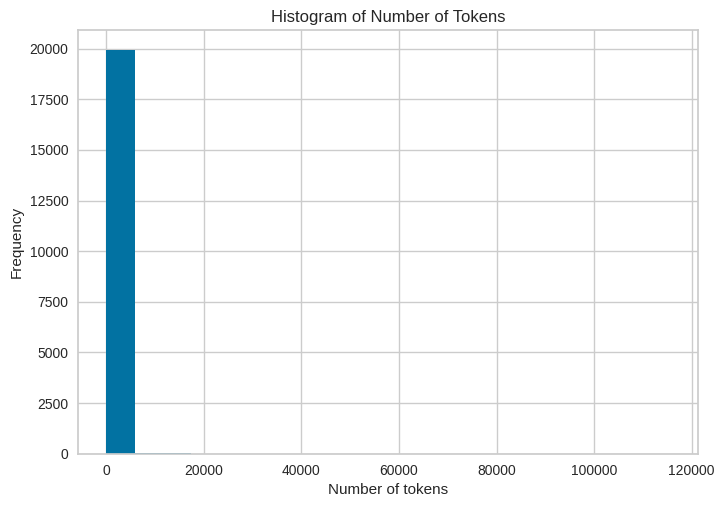

In [ ]:
plt.hist(nb_tokens, bins=20) # 20 is the number of bins you want to use
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens')
plt.show()

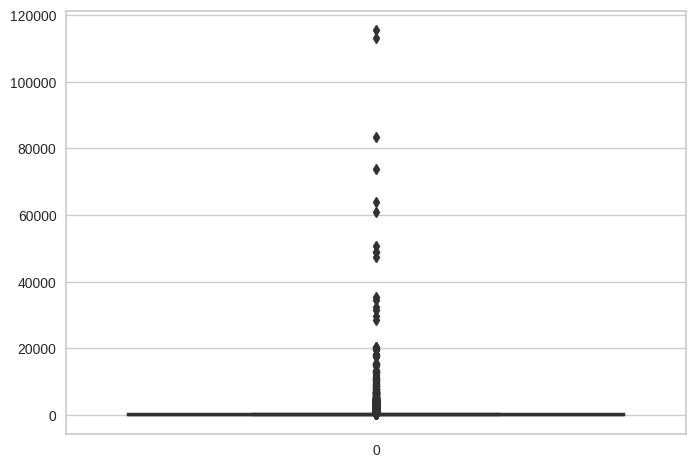

In [ ]:
plt.figure()
sns.boxplot(df_features['nb_tokens'])
plt.show()


As we can see, there are a relatively small number of very large documents which will need to be removed as most have around 21 tokens.

In [ ]:
#@title Filtering Options
min_tokens = 7 #@param { type:"integer" }
max_tokens = 70 #@param { type:"integer" }

In [ ]:
# Find out a range for `nb-tokens`
df_tokens = df_features[(df_features['nb_tokens'] >= min_tokens) & (df_features['nb_tokens'] <= max_tokens)]

nb_tokens = df_tokens['nb_tokens']
min_tokens = nb_tokens.min()
max_tokens = nb_tokens.max()
mean_tokens = nb_tokens.mean()
median_tokens = nb_tokens.median()

print(f"Minimum number of tokens: {min_tokens}")
print(f"Maximum number of tokens: {max_tokens}")
print("Mean number of tokens:", mean_tokens)
print("Median number of tokens:", median_tokens)

Minimum number of tokens: 7
Maximum number of tokens: 70
Mean number of tokens: 24.809953161592507
Median number of tokens: 21.0


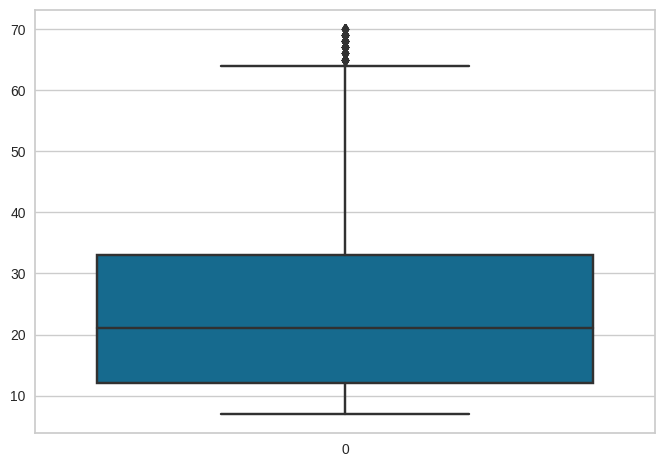

In [ ]:
plt.figure()
sns.boxplot(df_tokens['nb_tokens'].values)
plt.show()

After multiple adjustments, the optimal range of tokens appears to be between 7 and 70 tokens.

### Initial Filtering

After specifying the file containing our dataset, we load its contents into a `DataFrame` object. Some additional filtering is done on the dataset to eliminate rows:

* **Minimum Tokens**: We  filter out webpages that to not have the required minimum of tokens.
* **Maximum Tokens**: We also filter out webpages that have an outsized number of tokens,
* **Maximum Number of N-Grams**: The number of n-grams to include in our `CountVectorizer` object,
* **Non-English Webpages**: We only consider webpages written in English.


During the same filtering step, we are also going to drop all columns that have a constant value of 0:
*   mitsubishi_ufj
*   royal_mail
*   purolator
*   canada_post
*   facebook_messenger
*   tiktok
*   qq
*   wechat
*   weibo

In [ ]:
#@title Filtering Options
min_tokens = 7 #@param { type:"integer" }
max_tokens = 70 #@param { type:"integer" }
max_words = 250 #@param { type:"integer" }
english_only = True #@param { type:"boolean" }

In [ ]:
%%capture
# Remove rows containing foreign languages
if english_only and 'is_english' in df_features:
    df_features = df_features[df_features['is_english'] == True]

# Drop unneeded columns
if 'is_english' in df_features:
  df_features.drop('is_english', axis=1, inplace=True)

if 'title_raw' in df_features:
  df_features.drop('title_raw', axis=1, inplace=True)

# Remove columns that have a constant value 0

# mitsubishi_ufj
# royal_mail
# purolator
# canada_post
# facebook_messenger
# wechat
# tiktok
# qq
# weibo

if 'mitsubishi_ufj' in df_features:
  df_features.drop('mitsubishi_ufj', axis=1, inplace=True)

if 'royal_mail' in df_features:
  df_features.drop('royal_mail', axis=1, inplace=True)

if 'purolator' in df_features:
  df_features.drop('purolator', axis=1, inplace=True)

if 'canada_post' in df_features:
  df_features.drop('canada_post', axis=1, inplace=True)

if 'facebook_messenger' in df_features:
  df_features.drop('facebook_messenger', axis=1, inplace=True)

if 'wechat' in df_features:
  df_features.drop('wechat', axis=1, inplace=True)

if 'tiktok' in df_features:
  df_features.drop('tiktok', axis=1, inplace=True)

if 'qq' in df_features:
  df_features.drop('qq', axis=1, inplace=True)

if 'weibo' in df_features:
  df_features.drop('weibo', axis=1, inplace=True)  
  
# Keep rows with at the required amount of tokens
df_features = df_features[(df_features['nb_tokens'] >= min_tokens) & (df_features['nb_tokens'] <= max_tokens)]

# Remove misclassified rows
df_features = df_features[(df_features['classification'] == 'benign') | (df_features['classification'] == 'malicious')]

# Remove strings containing special characters or
# misparsed HTML tags and code.
df_features['text_clean'] = df_features['text_clean'].str.replace('_',' ',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('//',' ',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('javascript','',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('https','',regex=True)
df_features['text_clean'] = df_features['text_clean'].str.replace('http','',regex=True)

In [ ]:
# Save text_clean to cleaned_features table.
pd.DataFrame(df_features).to_sql("cleaned_features", con, if_exists="replace")

8205

### Dataset Information

We can now verify the remaining number of rows in our dataset. Using the sample of 20,000 websites results in a small dataset of 8,205 rows, which is relatively small. In a production environment, we would be using the full dataset of 380,000 samples, but for the sake of demonstrating the process, we will keep this small set for now.

#### Size

In [ ]:
print(f"The features dataset contains {df_features.shape[0]} rows and {df_features.shape[1]} columns.")

The features dataset contains 8205 rows and 38 columns.


#### Empty Columns

In [ ]:
df_features.isnull().sum()

title_clean          0
img_count            0
has_form             0
has_login_form       0
has_js               0
js_include_b64       0
nb_tokens            0
text_clean           0
classification       0
nb_title_entities    0
nb_text_entities     0
jpmorgan_chase       0
bank_of_america      0
wells_fargo          0
hsbc                 0
deutsche_bank        0
citibank             0
rbc                  0
paypal               0
scotiabank           0
apple                0
microsoft            0
amazon               0
google               0
samsung              0
facebook             0
steam                0
netflix              0
ups                  0
fedex                0
dhl                  0
tnt                  0
usps                 0
youtube              0
whatsapp             0
instagram            0
linkedin             0
twitter              0
dtype: int64

### Labels

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_features.head()

title_clean  img_count  has_form  has_login_form  \
0                         one drive          1         0               0   
4                          no title          6         1               1   
5   email security : : user account          0         1               1   
8           sign in to your account          4         1               1   
10                      worldclient          2         1               1   

    has_js  js_include_b64  nb_tokens  \
0        1               0         31   
4        0               0          7   
5        1               0         19   
8        0               0         14   
10       1               0         13   

                                           text_clean classification  \
0   one drive read document please choose email pr...      malicious   
4   gjin.jung samsung.com 3c 95338 2017 icp0803424...      malicious   
5   email security user account verification neede...      malicious   
8   sign account nobody mycraftmail.com enter pass...      malicious   
10  worldclient microsoft office verification port...      malicious   

    nb_title_entities  ...  ups  fedex  dhl  tnt  usps  youtube  whatsapp  \
0                 0.0  ...  0.0    0.0  0.0  0.0   0.0      0.0       0.0   
4                 0.0  ...  0.0    0.0  0.0  0.0   0.0      0.0       0.0   
5                 0.0  ...  0.0    0.0  0.0  0.0   0.0      0.0       0.0   
8                 0.0  ...  0.0    0.0  0.0  0.0   0.0      0.0       0.0   
10                0.0  ...  0.0    0.0  0.0  0.0   0.0      0.0       0.0   

    instagram  linkedin  twitter  
0         0.0       0.0      0.0  
4         0.0       0.0      0.0  
5         0.0       0.0      0.0  
8         0.0       0.0      0.0  
10        0.0       0.0      0.0  

[5 rows x 38 columns]

Text(0, 0.5, 'Count')

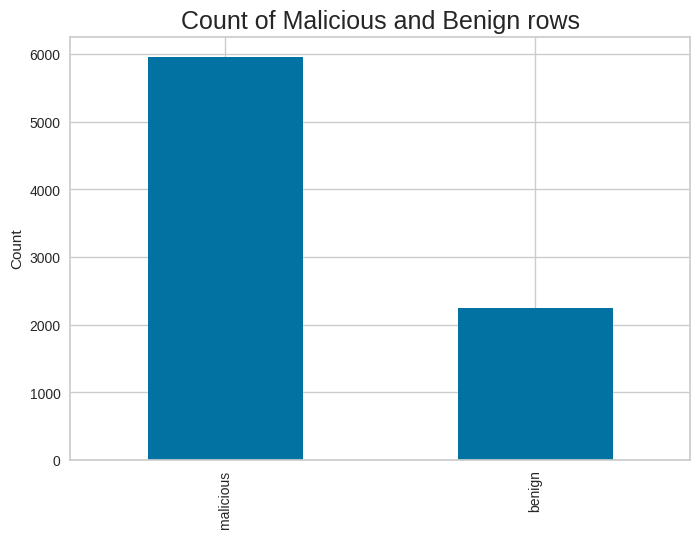

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['classification'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of Malicious and Benign rows",fontsize=18)
plt.ylabel("Count")

#### Form Data

Text(0, 0.5, 'Count')

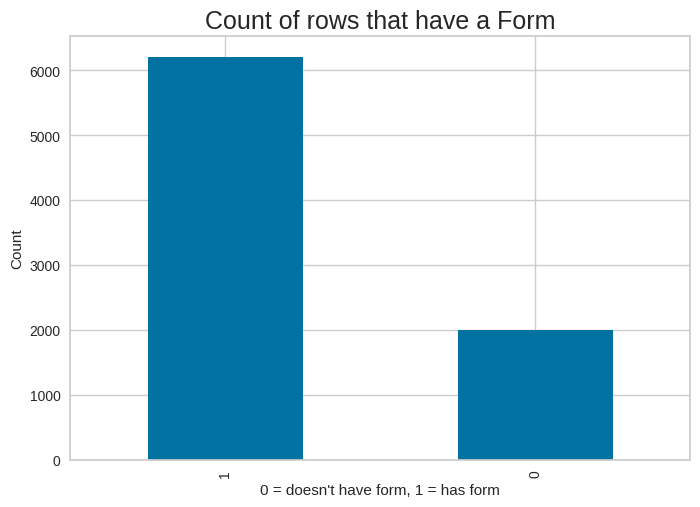

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['has_form'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have a Form", fontsize=18)
plt.xlabel("0 = doesn't have form, 1 = has form")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

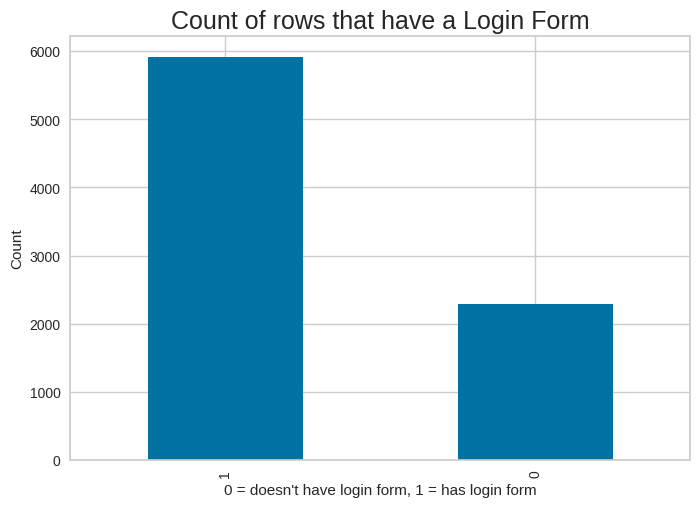

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['has_login_form'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have a Login Form", fontsize=18)
plt.xlabel("0 = doesn't have login form, 1 = has login form")
plt.ylabel("Count")

#### JavaScript Data

The presence of JavaScript from webpages is collected. _JavaScript_ is widely used on many webpages to provide dynamic content. It can also be used for cross-site scripting and inject remote malicious code in the page.

Text(0, 0.5, 'Count')

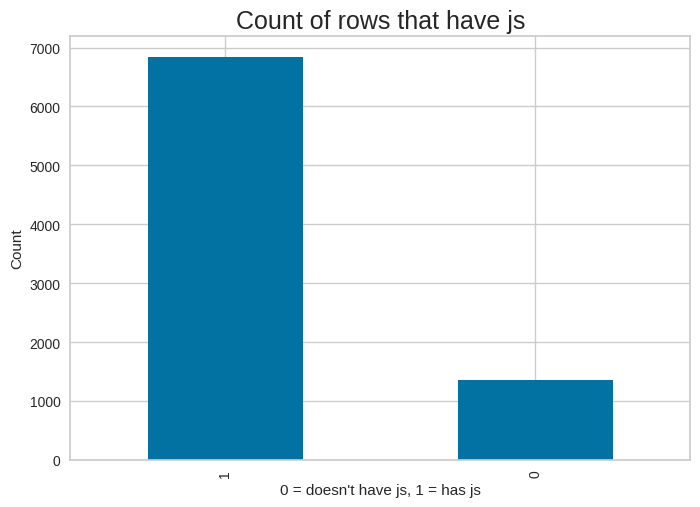

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['has_js'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have js", fontsize=18)
plt.xlabel("0 = doesn't have js, 1 = has js")
plt.ylabel("Count")

We collect information about the presence of Base64 encoded-string in webpages. _Base64_ is often used to obfuscated malicious JavaScript code. While this is not common, when this feature is present, there may be a high correlation between this feature the malicious webpages.

Text(0, 0.5, 'Count')

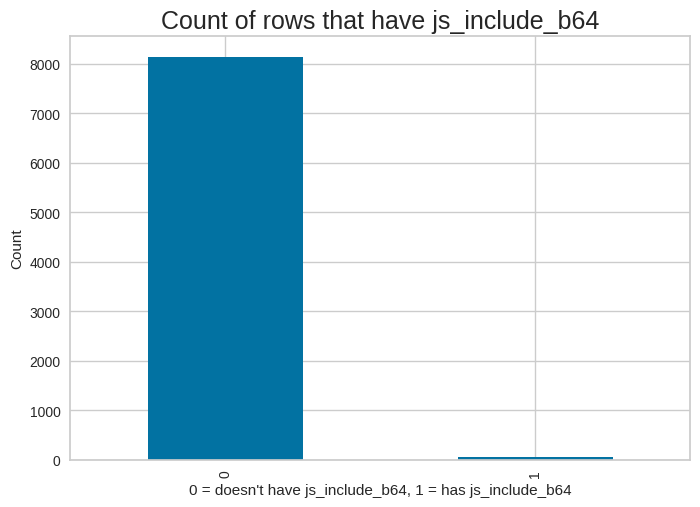

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['js_include_b64'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have js_include_b64", fontsize=18)
plt.xlabel("0 = doesn't have js_include_b64, 1 = has js_include_b64")
plt.ylabel("Count")

Text(0.5, 0, 'Number of images')

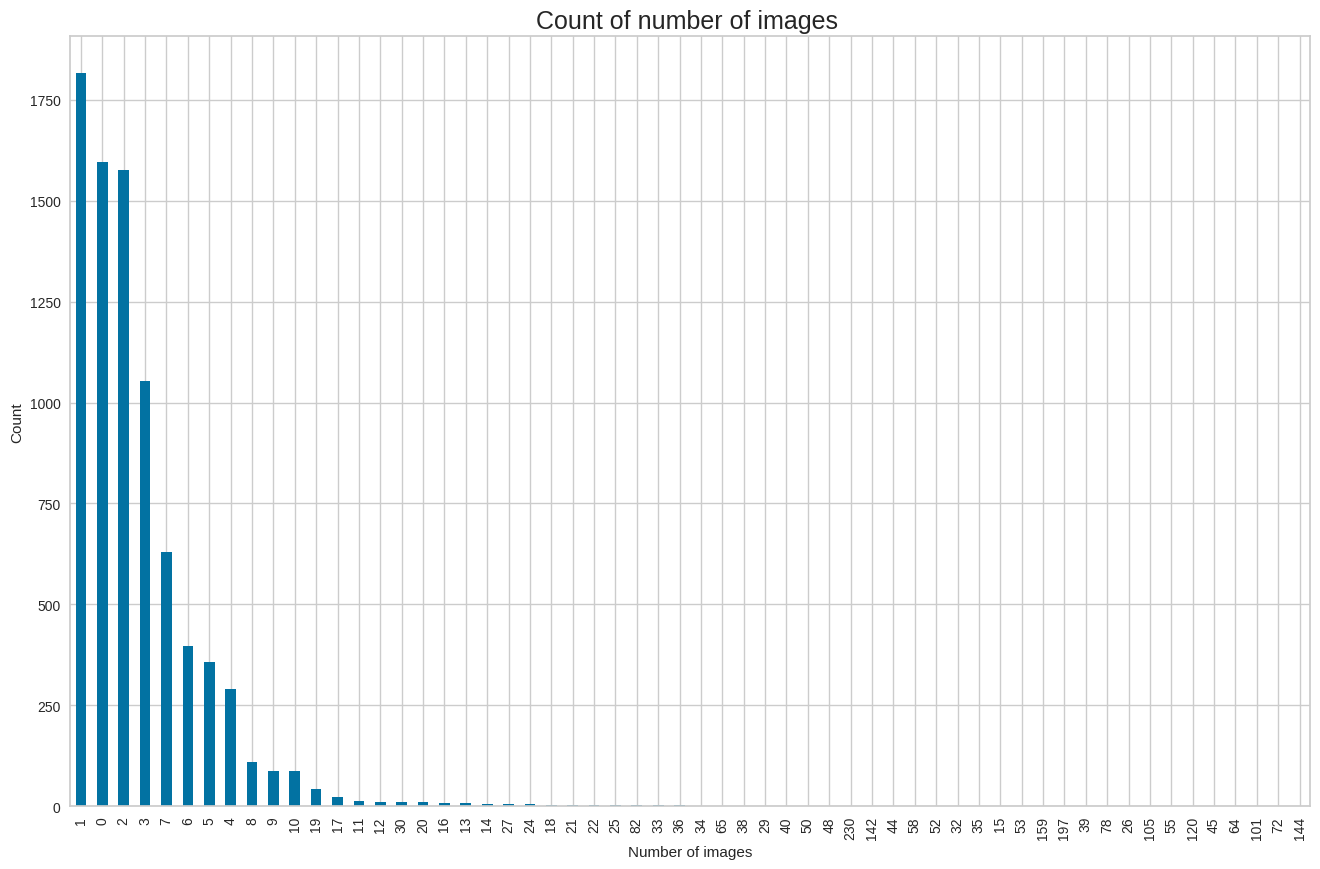

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['img_count'].value_counts()

# Plot the histogram
plt.figure(figsize=(16,10))
classification_counts.plot(kind='bar')
plt.title("Count of number of images ", fontsize=18)
plt.ylabel("Count")
plt.xlabel("Number of images")

Text(0.5, 0, 'nb_title_entities')

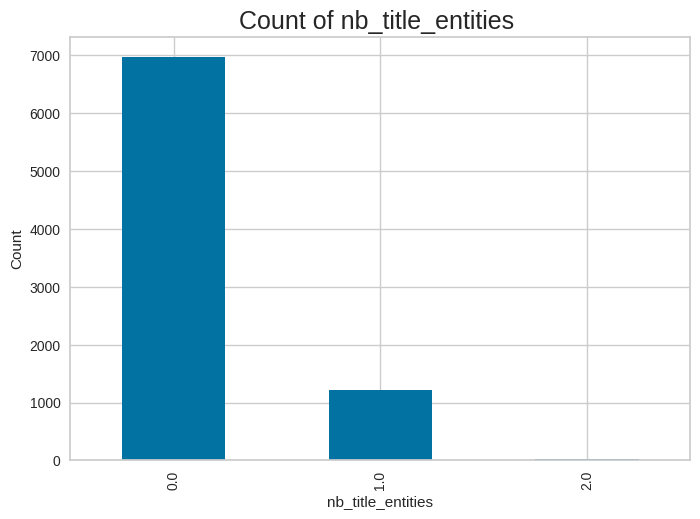

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['nb_title_entities'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of nb_title_entities ", fontsize=18)
plt.ylabel("Count")
plt.xlabel("nb_title_entities")

Text(0, 0.5, 'Count')

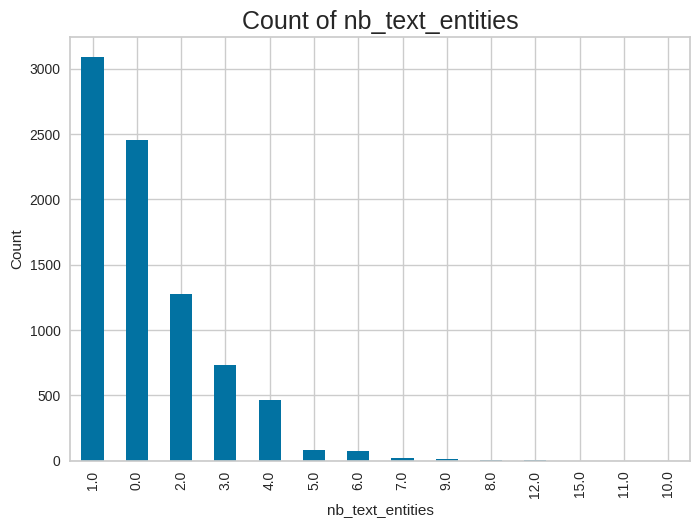

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['nb_text_entities'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of nb_text_entities", fontsize=18)
plt.xlabel("nb_text_entities")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

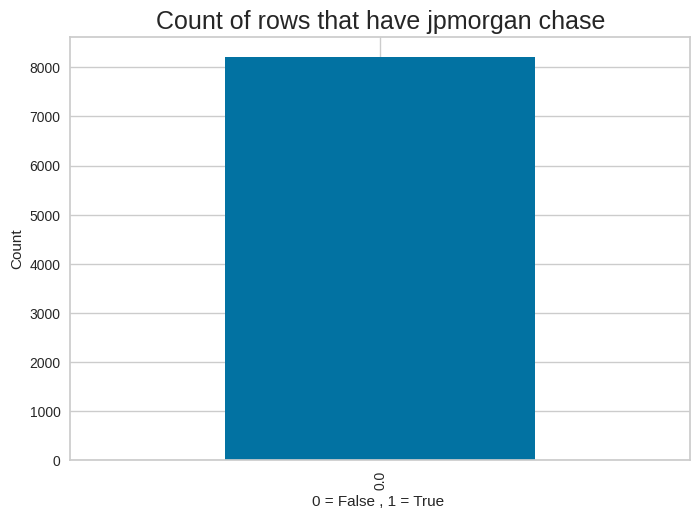

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['jpmorgan_chase'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have jpmorgan chase", fontsize=18)
plt.xlabel("0 = False , 1 = True ")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

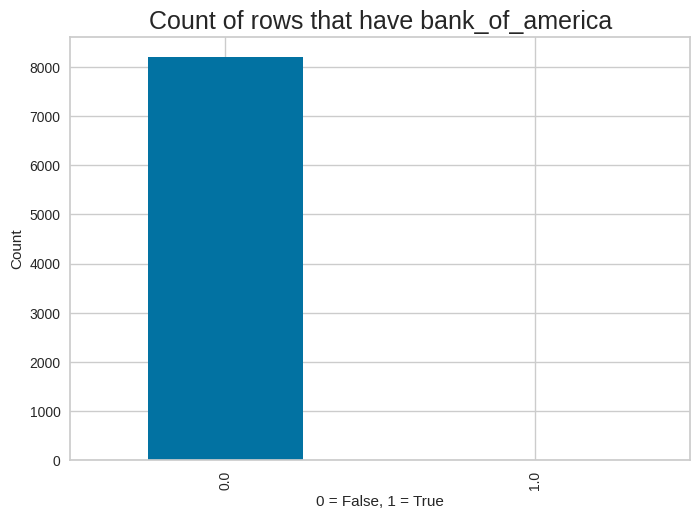

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['bank_of_america'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have bank_of_america", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

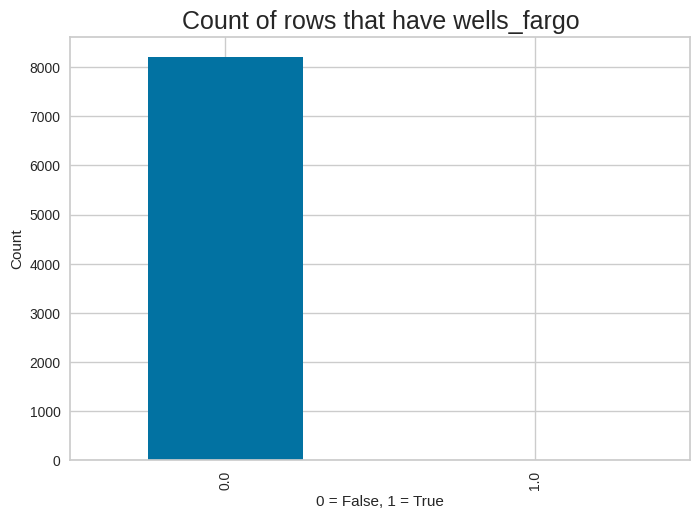

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['wells_fargo'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have wells_fargo", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

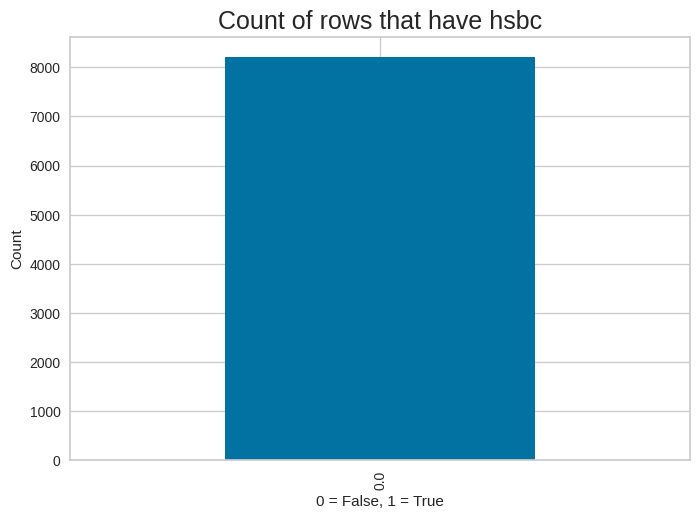

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['hsbc'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have hsbc", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

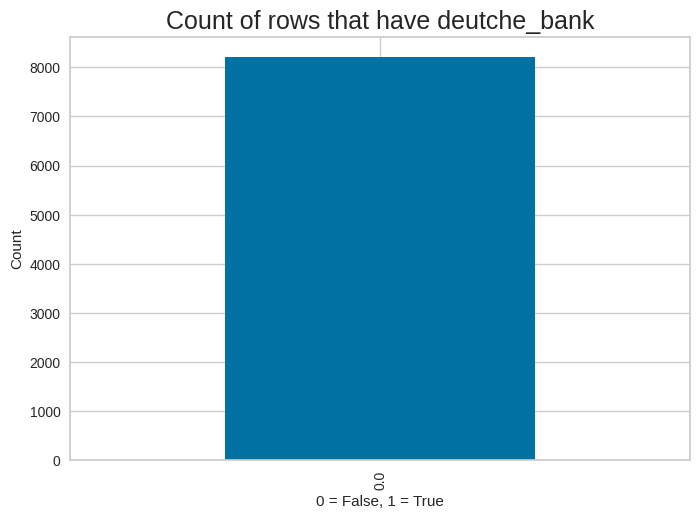

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['deutsche_bank'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have deutche_bank", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

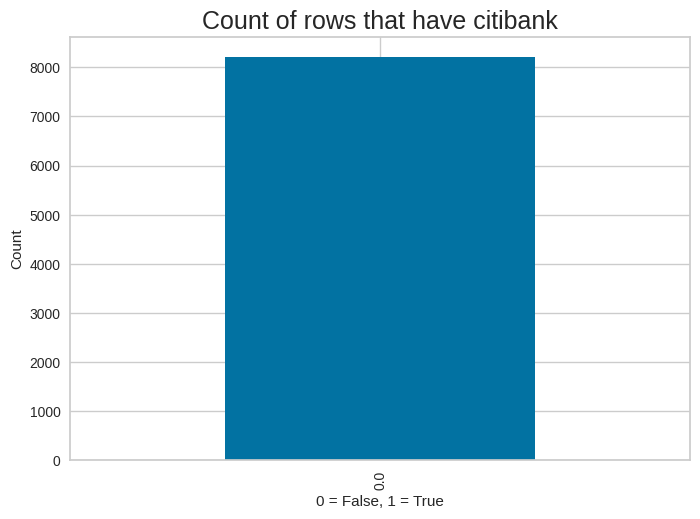

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['citibank'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have citibank",fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

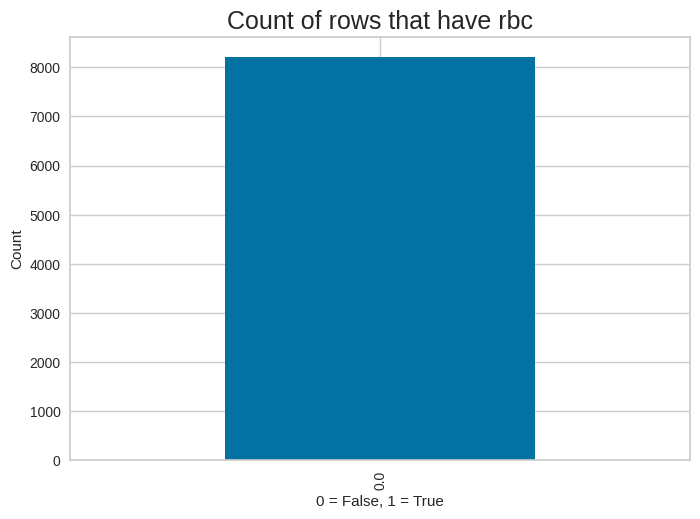

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['rbc'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have rbc", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

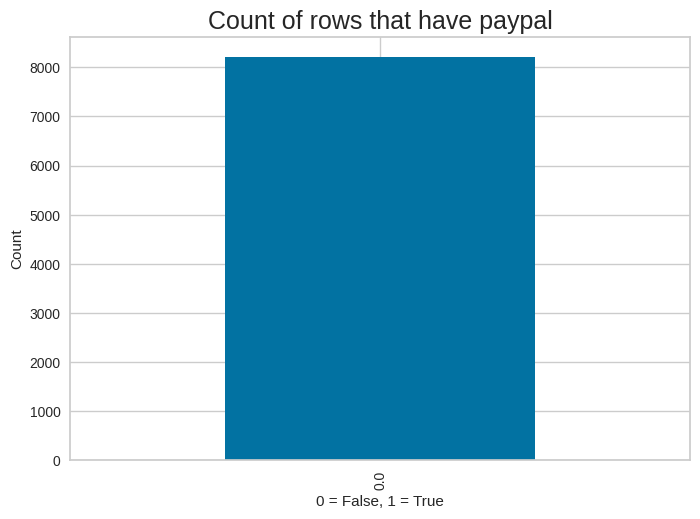

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['paypal'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have paypal", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

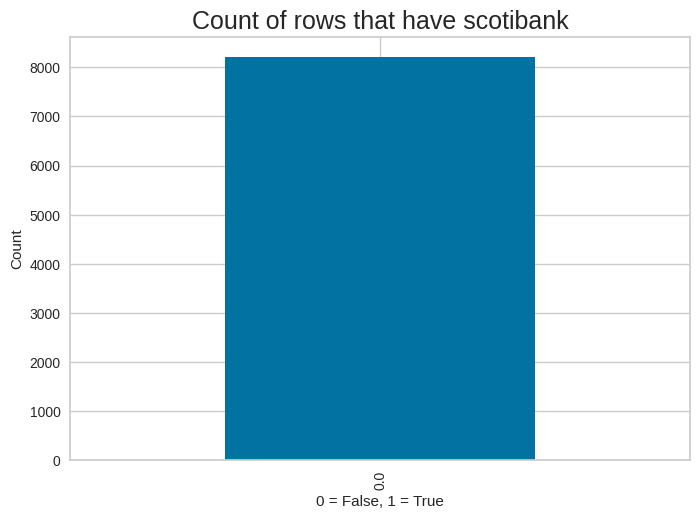

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['scotiabank'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have scotibank", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

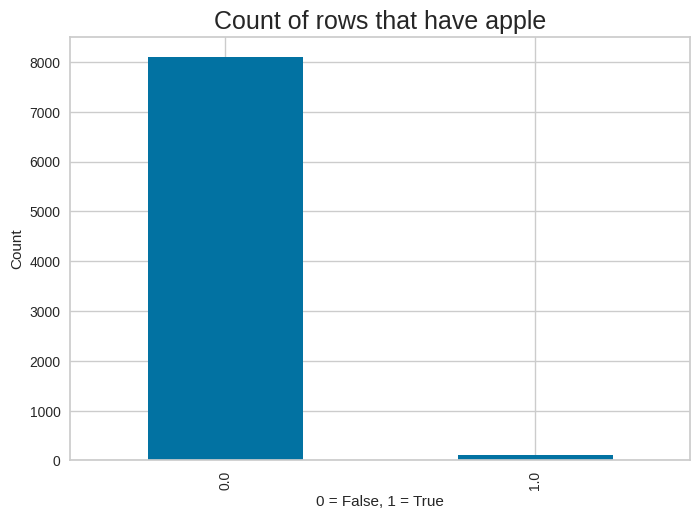

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['apple'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have apple", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

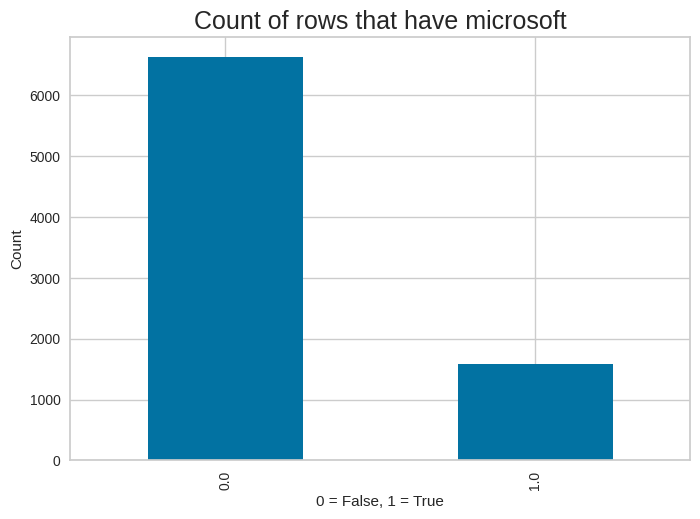

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['microsoft'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have microsoft", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

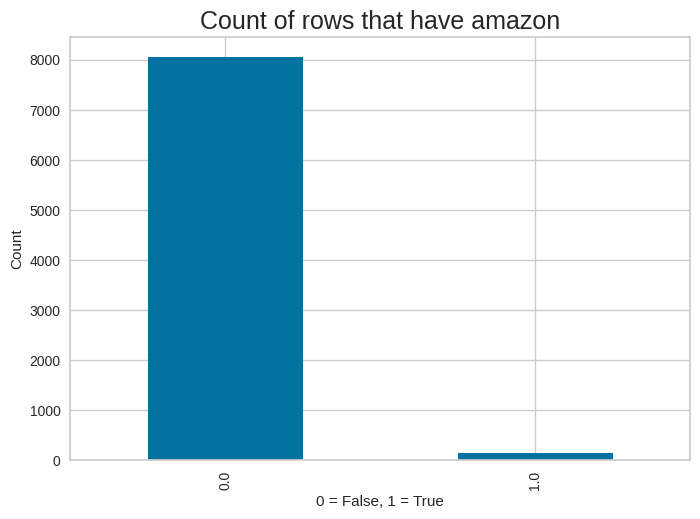

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['amazon'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have amazon", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

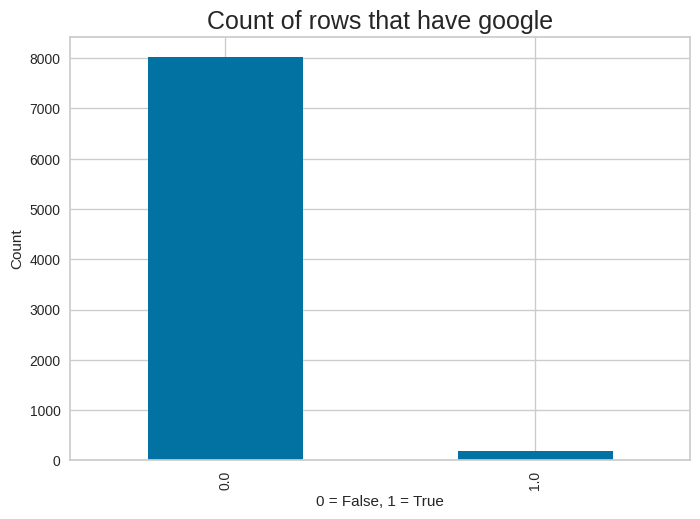

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['google'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have google", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

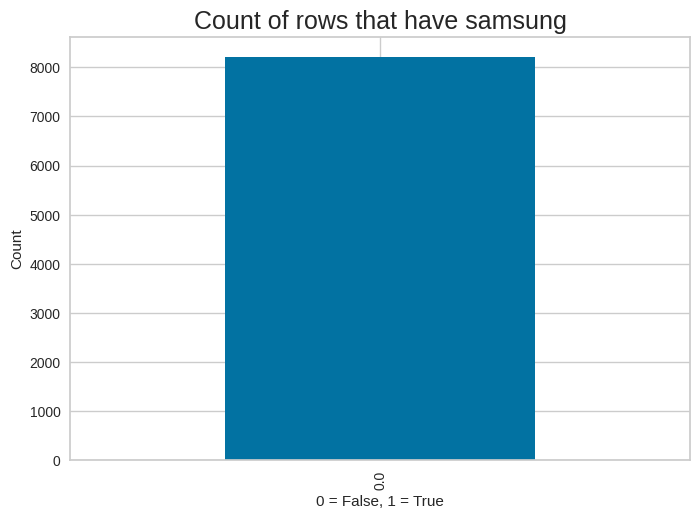

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['samsung'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have samsung", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

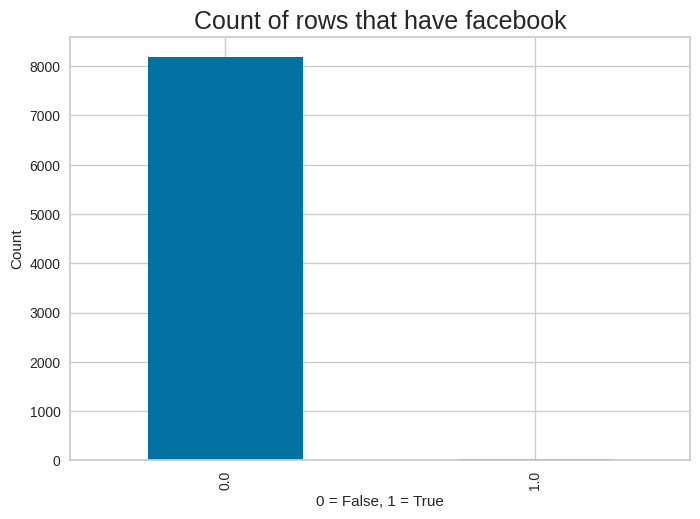

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['facebook'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have facebook", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

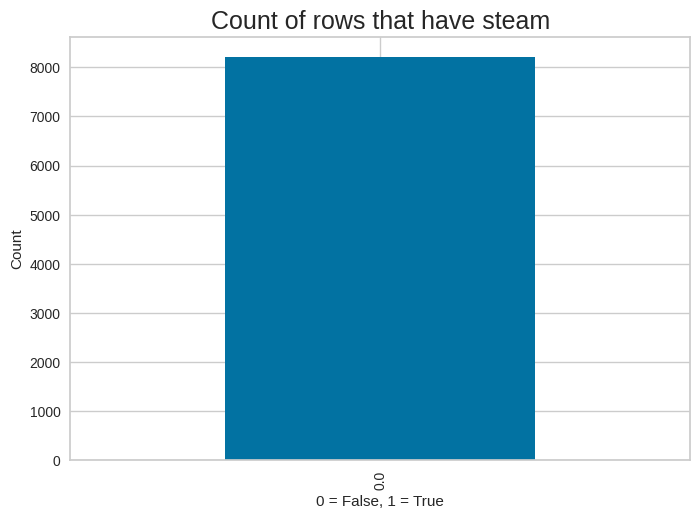

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['steam'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have steam", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

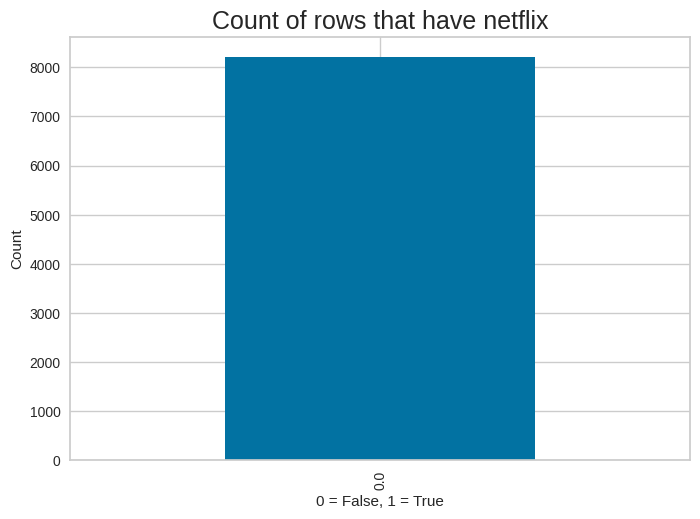

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['netflix'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have netflix", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

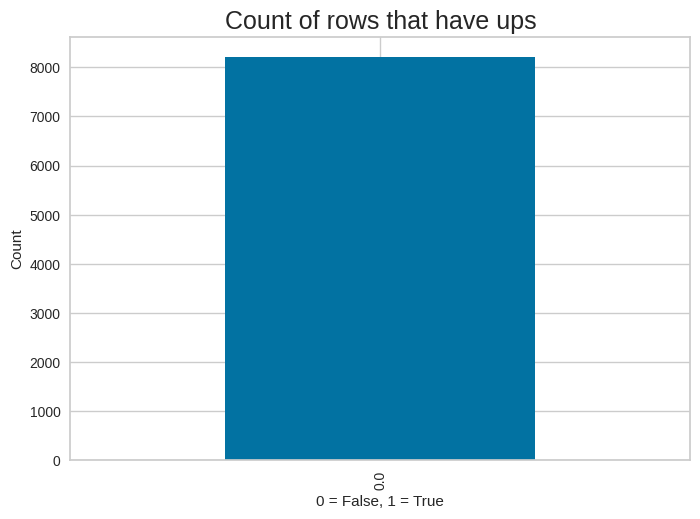

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['ups'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have ups", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

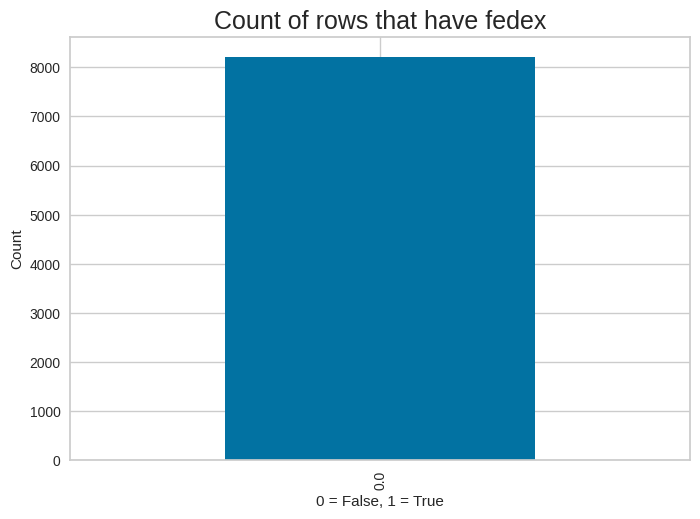

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['fedex'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have fedex", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

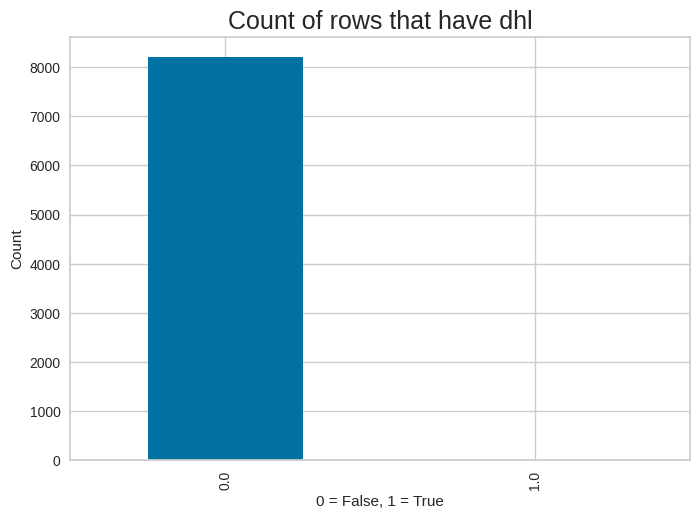

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['dhl'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have dhl", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

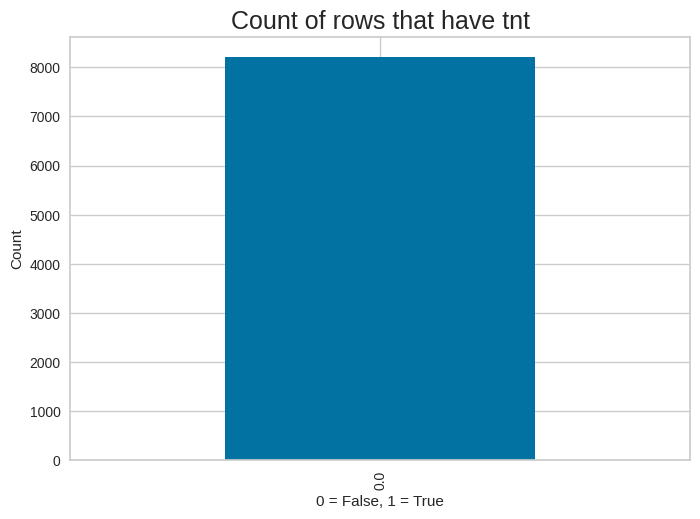

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['tnt'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have tnt", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

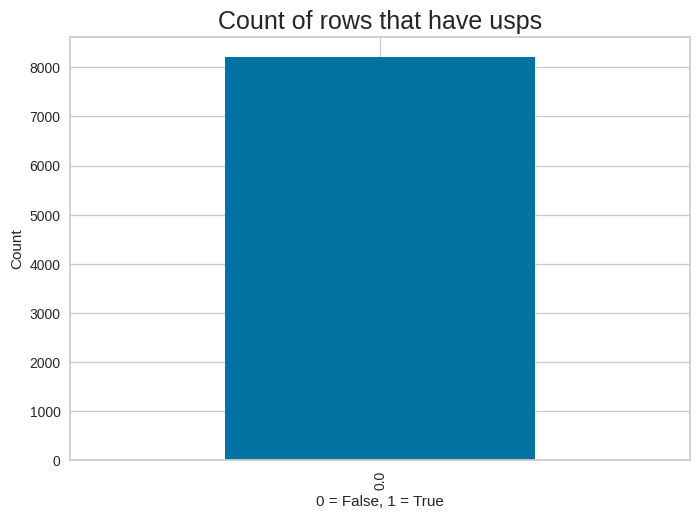

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['usps'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have usps", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

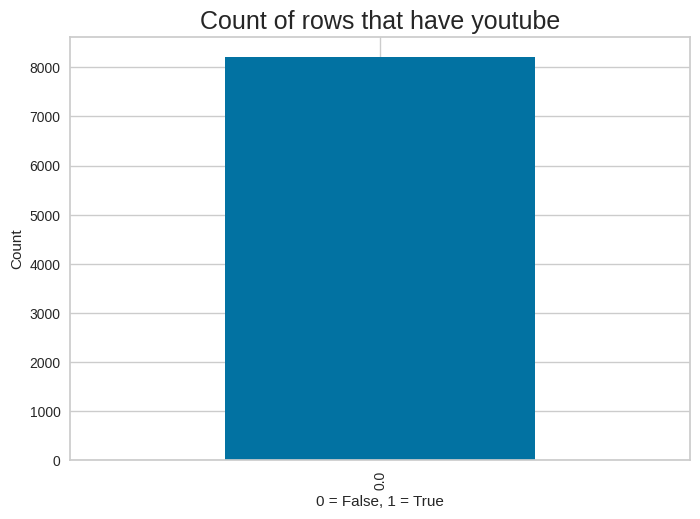

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['youtube'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have youtube", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

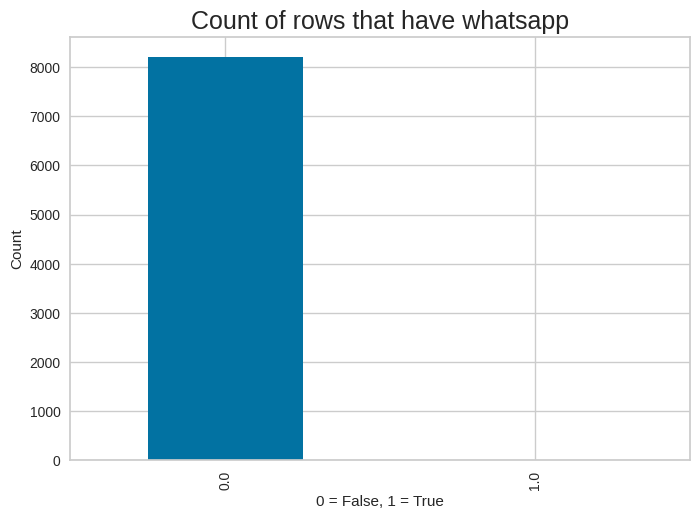

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['whatsapp'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have whatsapp", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

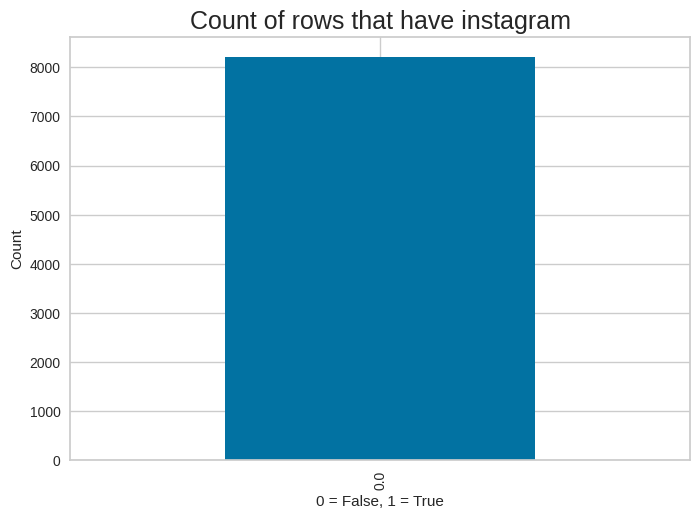

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['instagram'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have instagram", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

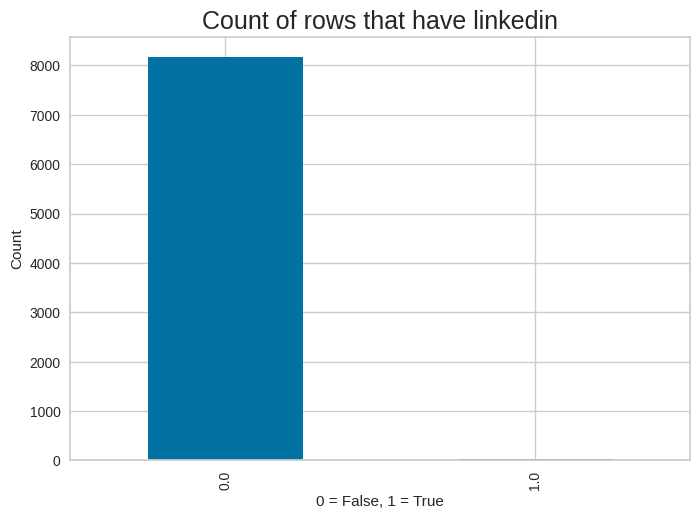

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['linkedin'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have linkedin", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

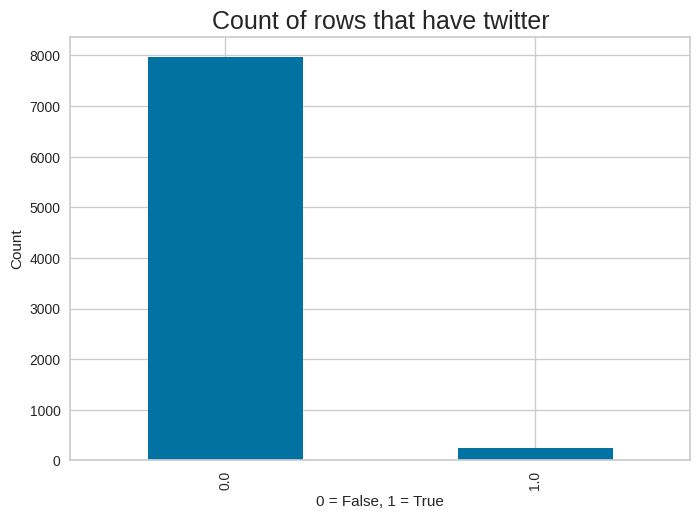

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['twitter'].value_counts()

# Plot the histogram
classification_counts.plot(kind='bar')
plt.title("Count of rows that have twitter", fontsize=18)
plt.xlabel("0 = False, 1 = True")
plt.ylabel("Count")

We then perform some additional cleaning and filtering on the dataset generated. 

### Review of Form Data

Text(0, 0.5, 'Count')

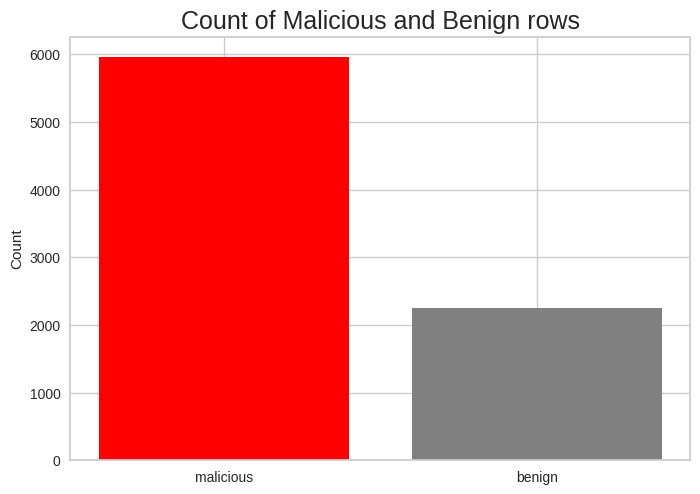

In [ ]:
# Assume "df_features" is your DataFrame object
classification_counts = df_features['classification'].value_counts()

# Plot the histogram
plt.bar(classification_counts.index,classification_counts, color=['red', 'grey'])
plt.title("Count of Malicious and Benign rows",fontsize=18)
plt.ylabel("Count")

In [ ]:
classification_counts

malicious    5959
benign       2246
Name: classification, dtype: int64

By reviewing the labels, we notice that there is a larger number of malicious samples than benign ones, which may require us to consider when generating our classifier to have a more balanced distribution.

We also discovered that after the initial filtering step where we limited the number of tokens, the following features now have a constant 0:
*   jpmorgan_chase
*   hsbc
*   deutsche_bank
*   citibank
*   paypal
*   scotiabank
*   samsung
*   steam
*   netflix
*   ups
*   fedex
*   tnt
*   usps
*   instagram

We are simply going to remove all these columns.

In [ ]:
# Remove columns that have a constant value 0 (after initial filtering)

# jpmorgan_chase
# hsbc
# deutsche_bank
# citibank
# paypal
# scotiabank
# samsung
# steam
# netflix
# ups
# fedex
# tnt
# usps
# instagram

if 'jpmorgan_chase' in df_features:
  df_features.drop('jpmorgan_chase', axis=1, inplace=True)

if 'hsbc' in df_features:
  df_features.drop('hsbc', axis=1, inplace=True)

if 'deutsche_bank' in df_features:
  df_features.drop('deutsche_bank', axis=1, inplace=True)

if 'rbc' in df_features:
  df_features.drop('rbc', axis=1, inplace=True)

if 'paypal' in df_features:
  df_features.drop('paypal', axis=1, inplace=True)

if 'scotiabank' in df_features:
  df_features.drop('scotiabank', axis=1, inplace=True)

if 'samsung' in df_features:
  df_features.drop('samsung', axis=1, inplace=True)

if 'steam' in df_features:
  df_features.drop('steam', axis=1, inplace=True)

if 'netflix' in df_features:
  df_features.drop('netflix', axis=1, inplace=True)

if 'ups' in df_features:
  df_features.drop('ups', axis=1, inplace=True)

if 'fedex' in df_features:
  df_features.drop('fedex', axis=1, inplace=True)

if 'tnt' in df_features:
  df_features.drop('tnt', axis=1, inplace=True)

if 'usps' in df_features:
  df_features.drop('usps', axis=1, inplace=True)

if 'instagram' in df_features:
  df_features.drop('instagram', axis=1, inplace=True)


The focus is then shifted into analysing the tokens extracted from the text of each website remaining in the dataset.

In [ ]:
# Save df_features to filtered_features table.
pd.DataFrame(df_features).to_sql("filtered_features", con, if_exists="replace")

8205

## Text Analysis

### Generate WordClouds

#### Helper functions

In [ ]:
def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string

In [ ]:
def unescape_stuff(x):
    soup = BeautifulSoup(unescape(x), 'lxml')
    return soup.text

In [ ]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string 

In [ ]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

#### Filter for Malicious and Consume the helper functions

In [ ]:
df_text_clean = df_features[(df_features['classification'] == 'malicious')][['text_clean']].copy()
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_urls)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(unescape_stuff)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_symbols)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(unify_whitespaces)

<ipython-input-71-cc4f7966ef48>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(unescape(x), 'lxml')


#### Prepare the stopwords removal function

In [ ]:
# Add custom stop words here:
custom_stop_words = ["com", "ca", "go", "td", "tr"
            "px", "co", "uv", "ru",
            "mx", "also", "use", "abc",
            "wo", "may", "oo", "javascript", "www",
            "html", "id", "class", "http", "https"]

cachedStopWords = sp.Defaults.stop_words
cachedStopWords = [x.lower() for x in cachedStopWords]
cachedStopWords.extend(list(stopwords.words('english')))
cachedStopWords.extend(list(custom_stop_words))
cachedStopWords = list(set(cachedStopWords))

def remove_stopwords(x):
    
    meaningful_words = []
    my_list = x
    
    tokenized_my_list = word_tokenize(my_list) 
    meaningful_words = [w for w in tokenized_my_list if not w in cachedStopWords]
        
    return " ".join(meaningful_words)

#### Remove english stopwords

In [ ]:
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_stopwords)

#### NGram function

In [ ]:
def get_ngrams(text, n=2):
    text = str(text)
    n_grams = ngrams(text.split(), n)
    returnVal = []
    
    try:
        for grams in n_grams:
            returnVal.append('_'.join(grams))
    except(RuntimeError):
        pass
        
    return ' '.join(returnVal).strip()

#### Extract the Malicious 1-grams

In [ ]:
df_text_clean["onegram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=1)

#### Extract the Malicious bigrams

In [ ]:
df_text_clean["bigram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=2)

#### Extract the Malicious trigrams



In [ ]:
df_text_clean["trigram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=3)

### Creating a List of Tokens from a List of Documents

In [ ]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [ ]:
# transform list of documents into a single list of tokens
onegram_tokens = df_text_clean.onegram_text.map(my_tokenizer).sum()
bigram_tokens = df_text_clean.bigram_text.map(my_tokenizer).sum()
trigram_tokens = df_text_clean.trigram_text.map(my_tokenizer).sum()

In [ ]:
from collections import Counter

### Most Common Malicious Words

#### Most Common Malicious Unigrams

In [ ]:
onegram_counter = Counter(onegram_tokens)
onegram_counter.most_common(20)

[('sign', 6899),
 ('account', 6084),
 ('password', 5880),
 ('login', 2816),
 ('microsoft', 2565),
 ('privacy', 2444),
 ('enter', 2312),
 ('email', 2225),
 ('term', 1940),
 ('cooky', 1933),
 ('webmail', 1639),
 ('mycraftmail', 1422),
 ('forgot', 1411),
 ('signed', 1155),
 ('n', 1134),
 ('document', 1010),
 ('create', 923),
 ('access', 917),
 ('2019', 916),
 ('security', 889)]

Most Common Malicious Unigrams


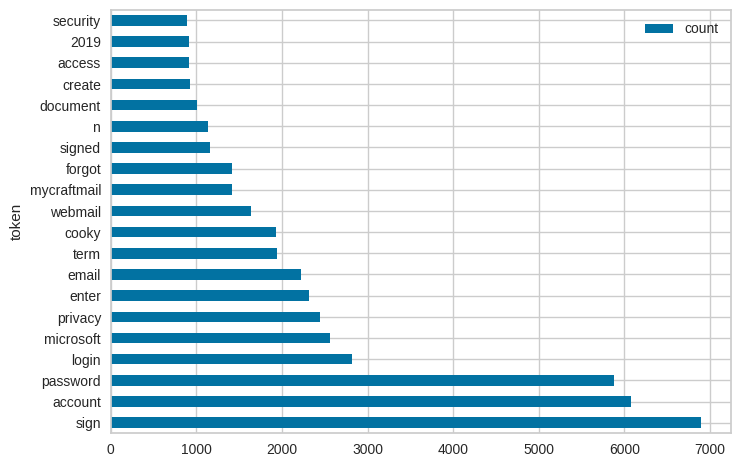

In [ ]:
print('Most Common Malicious Unigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(onegram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

#### Most Common Malicious bigrams

In [ ]:
bigram_counter = Counter(bigram_tokens)
bigram_counter.most_common(20)

[('privacy_cooky', 1792),
 ('enter_password', 1518),
 ('sign_account', 1404),
 ('forgot_password', 1227),
 ('term_privacy', 1218),
 ('microsoft_term', 855),
 ('microsoft_account', 849),
 ('account_create', 812),
 ('account_sign', 802),
 ('right_reserved', 689),
 ('password_sign', 685),
 ('account_account', 627),
 ('username_password', 624),
 ('email_address', 611),
 ('signed_forgot', 609),
 ('email_password', 592),
 ('sign_microsoft', 584),
 ('access_account', 544),
 ('2019_microsoft', 510),
 ('password_signed', 505)]

Most Common Malicious bigrams


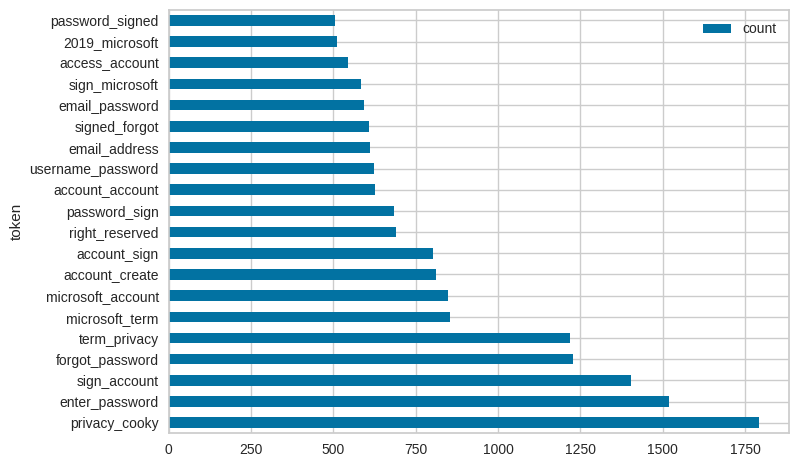

In [ ]:
print('Most Common Malicious bigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(bigram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

#### Most Common Malicious trigrams

In [ ]:
trigram_counter = Counter(trigram_tokens)
trigram_counter.most_common(20)

[('term_privacy_cooky', 1166),
 ('microsoft_term_privacy', 854),
 ('signed_forgot_password', 609),
 ('sign_microsoft_account', 521),
 ('enter_password_signed', 443),
 ('sign_security_key', 429),
 ('security_key_sign', 428),
 ('key_sign_option', 428),
 ('mycraftmail_enter_password', 410),
 ('account_create_sign', 409),
 ('account_mycraftmail_enter', 407),
 ('create_sign_security', 406),
 ('password_signed_forgot', 401),
 ('forgot_password_sign', 399),
 ('account_account_create', 386),
 ('inc_right_reserved', 380),
 ('2019_microsoft_term', 373),
 ('privacy_cooky_term', 372),
 ('sign_account_sign', 367),
 ('username_password_webmail', 348)]

Most Common Malicious trigrams


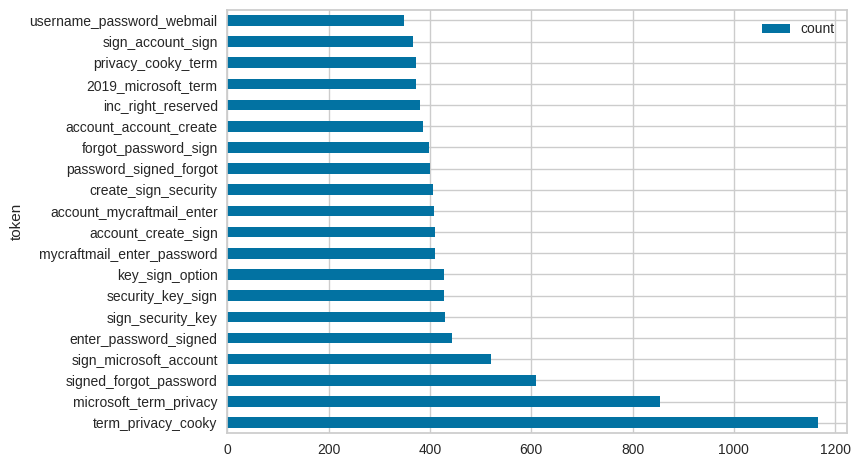

In [ ]:
print('Most Common Malicious trigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(trigram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

### Malicious Unigram WordCloud

#### Put the Malicious Unigrams in one long string



In [ ]:
onegram_string_list = df_text_clean['onegram_text'].tolist()
onegram_string = ' '.join(onegram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=200, 
                      collocations=False, 
                      normalize_plurals=False).generate(onegram_string)

#### Plot the Malicious Unigrams

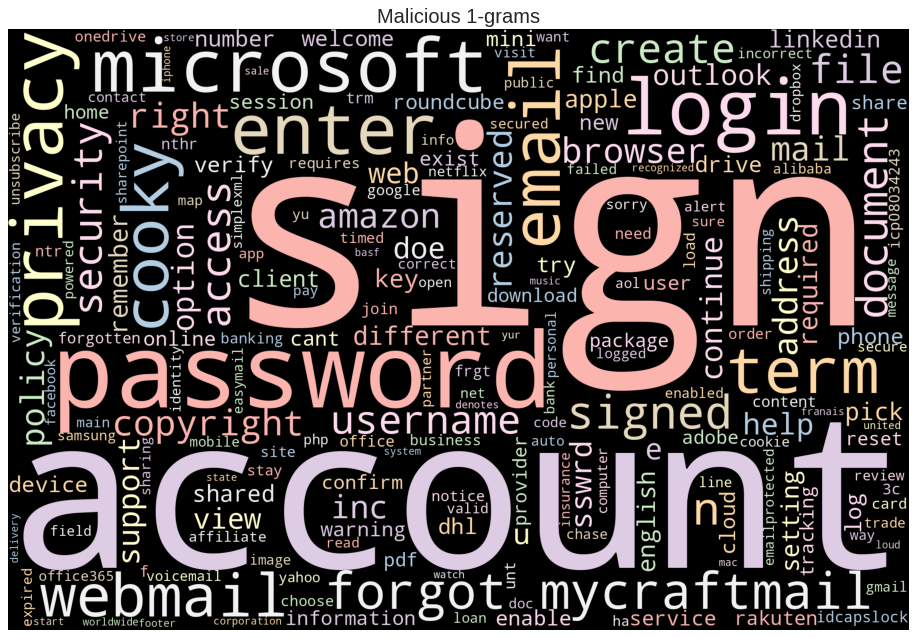

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Malicious 1-grams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
#Plot
plot_cloud(wordcloud)   

### Malicious Bigram WordCloud

#### Put the Malicious bigrams in one long string

In [ ]:
bigram_string_list = df_text_clean['bigram_text'].tolist()
bigram_string = ' '.join(bigram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=75, 
                      collocations=False, 
                      normalize_plurals=False).generate(bigram_string)

#### Plot the Malicious bigrams

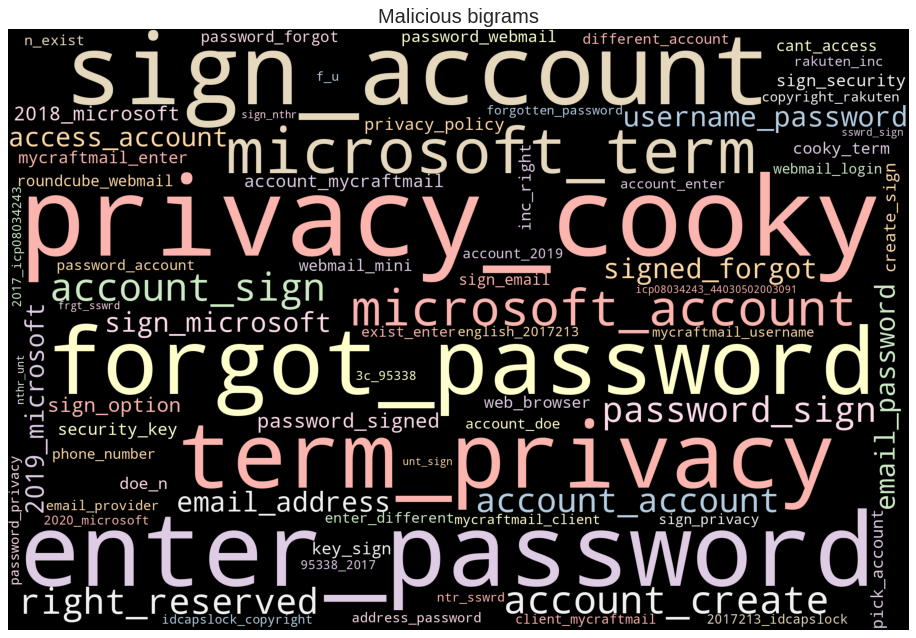

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Malicious bigrams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
#Plot
plot_cloud(wordcloud)   

### Malicious Trigram WordCloud

#### Put the Malicious trigrams in one long string

In [ ]:
trigram_string_list = df_text_clean['trigram_text'].tolist()
trigram_string = ' '.join(trigram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=50, 
                      collocations=False, 
                      normalize_plurals=False).generate(trigram_string)

#### Plot the Malicious trigrams

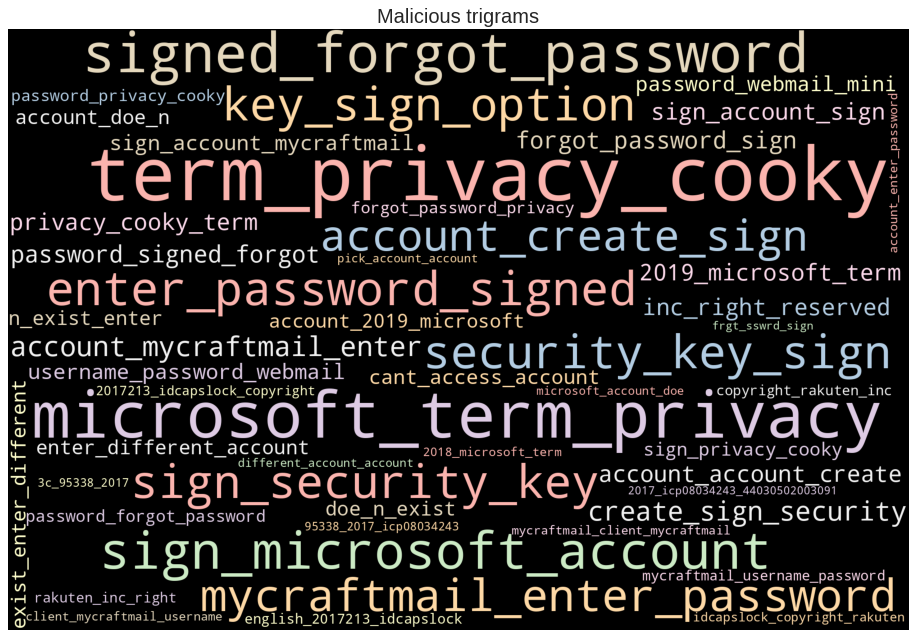

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Malicious trigrams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 

plot_cloud(wordcloud)

#### Filter for Benign and Consume the helper functions

In [ ]:
df_text_clean = df_features[(df_features['classification'] == 'benign')][['text_clean']].copy()
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_urls)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(unescape_stuff)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_symbols)
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(unify_whitespaces)

<ipython-input-71-cc4f7966ef48>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(unescape(x), 'lxml')


#### Remove english stopwords

In [ ]:
df_text_clean['text_clean'] = df_text_clean['text_clean'].apply(remove_stopwords)

#### Extract the Benign Unigrams

In [ ]:
df_text_clean["onegram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=1)

#### Extract the Benign bigrams

In [ ]:
df_text_clean["bigram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=2)

#### Extract the Benign trigrams

In [ ]:
df_text_clean["trigram_text"] = df_text_clean["text_clean"].apply(get_ngrams, n=3)

### Creating a List of Tokens from a List of Documents

In [ ]:
# transform list of documents into a single list of tokens
onegram_tokens = df_text_clean.onegram_text.map(my_tokenizer).sum()
bigram_tokens = df_text_clean.bigram_text.map(my_tokenizer).sum()
trigram_tokens = df_text_clean.trigram_text.map(my_tokenizer).sum()

### Most Common Benign Words

#### Most Common Benign Unigrams

In [ ]:
onegram_counter = Counter(onegram_tokens)
onegram_counter.most_common(20)

[('email', 1467),
 ('password', 1124),
 ('sign', 1023),
 ('login', 888),
 ('account', 856),
 ('privacy', 654),
 ('browser', 598),
 ('term', 579),
 ('google', 539),
 ('contact', 522),
 ('help', 520),
 ('address', 503),
 ('1', 466),
 ('debtwire', 465),
 ('policy', 448),
 ('support', 404),
 ('disabled', 398),
 ('cooky', 382),
 ('2020', 351),
 ('u', 348)]

Most Common Benign Unigrams


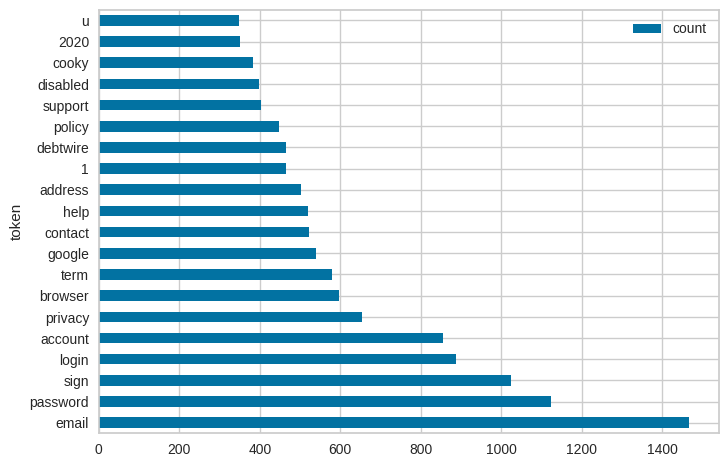

In [ ]:
print('Most Common Benign Unigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(onegram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

#### Most Common Benign bigrams

In [ ]:
bigram_counter = Counter(bigram_tokens)
bigram_counter.most_common(20)

[('email_address', 454),
 ('disabled_browser', 382),
 ('debtwire_login', 310),
 ('right_reserved', 266),
 ('password_remember', 265),
 ('forgot_password', 239),
 ('went_wrong', 239),
 ('detected_disabled', 229),
 ('browser_like', 229),
 ('like_proceed', 229),
 ('proceed_legacy', 229),
 ('legacy_twitter', 229),
 ('twitter_yes', 229),
 ('yes_went', 229),
 ('wrong_dont', 229),
 ('dont_fret', 229),
 ('fret_let', 229),
 ('let_shot', 229),
 ('privacy_policy', 209),
 ('cookie_policy', 198)]

Most Common Benign bigrams


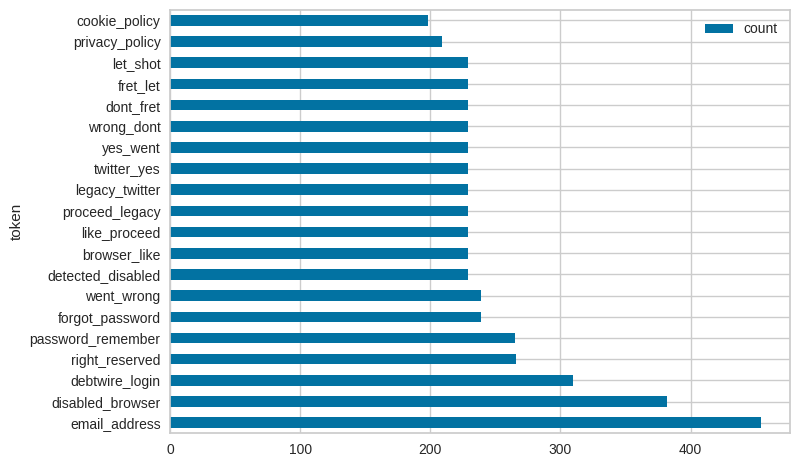

In [ ]:
print('Most Common Benign bigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(bigram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

#### Most Common Benign trigrams

In [ ]:
trigram_counter = Counter(trigram_tokens)
trigram_counter.most_common(20)

[('detected_disabled_browser', 229),
 ('disabled_browser_like', 229),
 ('browser_like_proceed', 229),
 ('like_proceed_legacy', 229),
 ('proceed_legacy_twitter', 229),
 ('legacy_twitter_yes', 229),
 ('twitter_yes_went', 229),
 ('yes_went_wrong', 229),
 ('went_wrong_dont', 229),
 ('wrong_dont_fret', 229),
 ('dont_fret_let', 229),
 ('fret_let_shot', 229),
 ('password_logging_agree', 158),
 ('debtwire_login_debtwire', 155),
 ('login_debtwire_login', 155),
 ('debtwire_login_debtwirecreated', 155),
 ('login_debtwirecreated_sketch', 155),
 ('debtwirecreated_sketch_sign', 155),
 ('sketch_sign_username', 155),
 ('sign_username_cap', 155)]

Most Common Benign trigrams


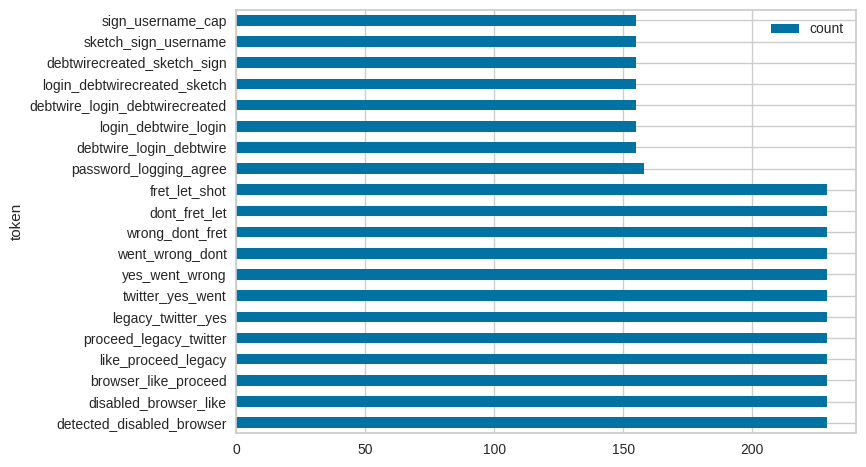

In [ ]:
print('Most Common Benign trigrams')

# convert list of tuples into data frame
most_common_words_df = pd.DataFrame.from_records(trigram_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
most_common_words_df.plot(kind='barh', x='token');

### Benign Unigram WordCloud

#### Put the Benign Unigrams in one long string

In [ ]:
onegram_string_list = df_text_clean['onegram_text'].tolist()
onegram_string = ' '.join(onegram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=200, 
                      collocations=False, 
                      normalize_plurals=False).generate(onegram_string)

#### Plot the Benign Unigrams

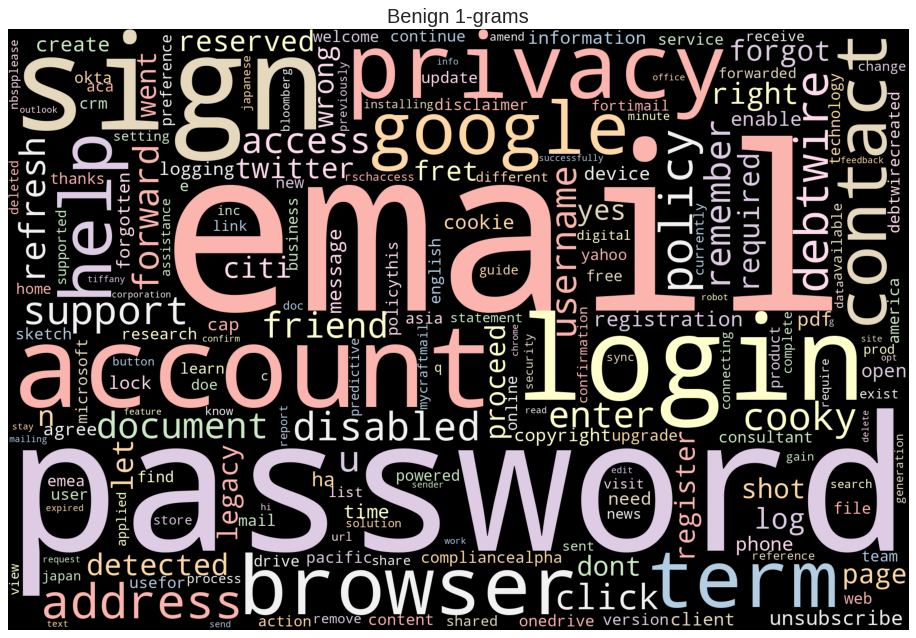

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Benign 1-grams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
#Plot
plot_cloud(wordcloud)   

### Benign Bigram WordCloud

#### Put the Benign bigrams in one long string

In [ ]:
bigram_string_list = df_text_clean['bigram_text'].tolist()
bigram_string = ' '.join(bigram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=75, 
                      collocations=False, 
                      normalize_plurals=False).generate(bigram_string)

#### Plot the Benign bigrams

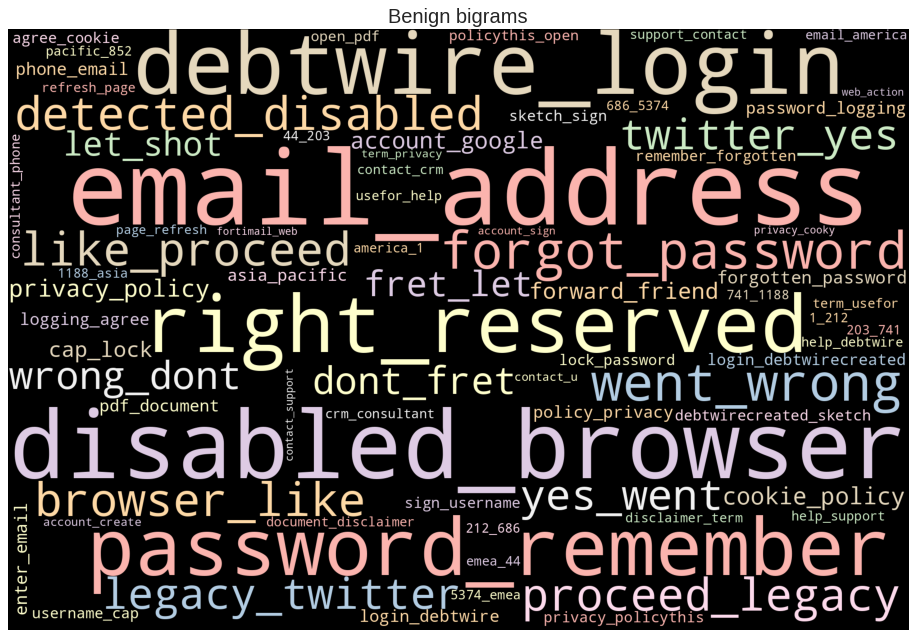

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Benign bigrams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 
   
#Plot
plot_cloud(wordcloud)   

### Benign Trigram WordCloud

#### Put the Benign trigrams in one long string

In [ ]:
trigram_string_list = df_text_clean['trigram_text'].tolist()
trigram_string = ' '.join(trigram_string_list)

In [ ]:
wordcloud = WordCloud(width=2000, 
                      height=1334, 
                      random_state=1, 
                      background_color='black', 
                      colormap='Pastel1', 
                      max_words=50, 
                      collocations=False, 
                      normalize_plurals=False).generate(trigram_string)

#### Plot the Benign trigrams

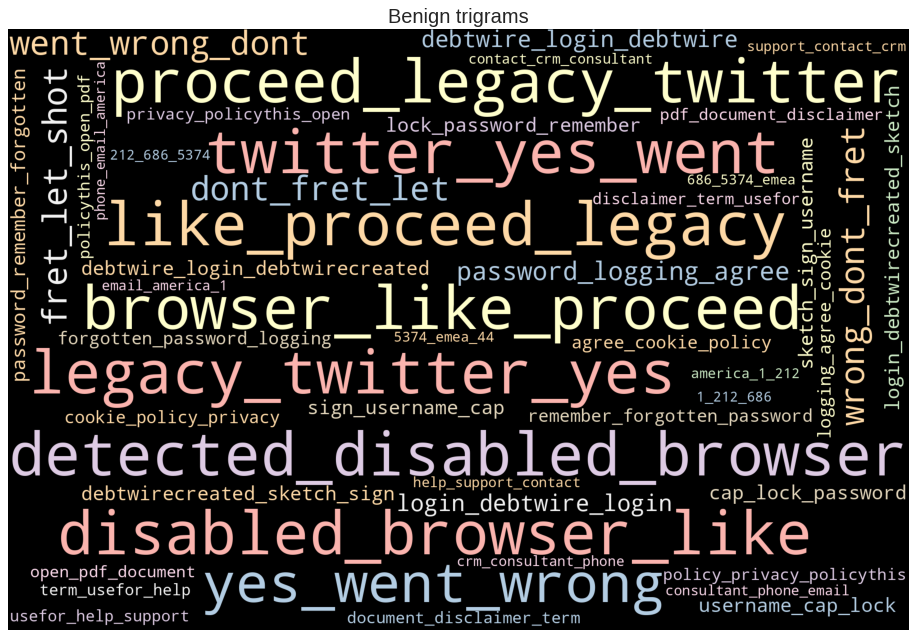

In [ ]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    fig = plt.figure(figsize=(12, 8), dpi=80)
    plt.title("Benign trigrams", fontsize=18)
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.box(False)
    plt.show()
    plt.close() 

plot_cloud(wordcloud)

### Text Analysis Summary

When inspecting the top 20 Unigrams the following 8 words appear in both Malicious and Benign lists:
*   email
*   password
*   sign
*   login
*   account
*   privacy
*   term
*   cooky

When inspecting the top 20 bigrams the following 3 words appear in both Malicious and Benign lists:
*   email_address
*   right_reserved
*   forgot_password

When inspecting the top 20 trigrams none appear in both lists. 

Since it is very difficult to classify an email as Malicious or Benign based on Unigrams, we will perform our classification based on bigrams and trigrams.



## Feature Engineering

### Stop Words

After multiple iterations, custom stop words were included from the default English stop words from the `ntlk` framework. These includes:

* **ccTLDs**. Country-Coded Top-Level Domains associated with URLs embedded in some webpages. While the entire URL is useful, the country code, by itself, is not;
* **HTML tags**. Despite the parser's best efforts, some HTML tags remain embedded in the code. As such, we try to reduce some of the HTML code left behind;
* **Adverbs**. Some adverbs, such as _also_ or _may_ are not useful to the analysis.

In [ ]:
# Load the default list of English stop words
default_stop_words = stopwords.words('english')

# Create the classifier
# Pass the complete dataset as data and the featured to be predicted as target
# Add custom stop words here:
custom_stop_words = ["com", "ca", "go", "td", "tr"
            "px", "co", "uv", "ru",
            "mx", "also", "use", "abc",
            "wo", "may", "oo", "javascript", "www",
            "html", "id", "class", "http", "https"]

# Append the custom list to the default list of stop words
stop_words = default_stop_words + custom_stop_words


## Extracting features from text

In [ ]:
# Define a custom token pattern that matches only alphabetic characters
pattern = r'\b[A-Za-z]+\b'

# Create a CountVectorizer
# We keep only bigrams and trigrams
# We remove words not within the [0.015, 0.8] frequency
count_vectorizer = CountVectorizer(min_df=0.015, 
                                   max_df=0.8, 
                                   stop_words=stop_words, 
                                   max_features=max_words, 
                                   ngram_range=(2, 3),
                                   token_pattern=pattern)

# Fit the vectorizer to the text data and transform the data
X = count_vectorizer.fit_transform(df_features['text_clean'])

df_words = pd.DataFrame(data=X.toarray(), columns = count_vectorizer.get_feature_names_out())

df_words.head()

access account  account account  account account create  account another  \
0               0                0                       0                0   
1               0                0                       0                0   
2               0                0                       0                0   
3               0                0                       0                0   
4               0                0                       0                0   

   account another account  account create  account create one  account doe  \
0                        0               0                   0            0   
1                        0               0                   0            0   
2                        0               0                   0            0   
3                        0               0                   0            0   
4                        0               0                   0            0   

   account doe n  account enter  ...  webmail mini  webmail welcome  \
0              0              0  ...             0                0   
1              0              0  ...             0                0   
2              0              0  ...             0                0   
3              0              0  ...             0                0   
4              0              0  ...             0                0   

   went wrong  went wrong dont  would like  would like proceed  wrong dont  \
0           0                0           0                   0           0   
1           0                0           0                   0           0   
2           0                0           0                   0           0   
3           0                0           0                   0           0   
4           0                0           0                   0           0   

   wrong dont fret  yes something  yes something went  
0                0              0                   0  
1                0              0                   0  
2                0              0                   0  
3                0              0                   0  
4                0              0                   0  

[5 rows x 250 columns]

## Combine vector of ngrams with other features

In [ ]:
# Reset the index of the two DataFrames
df_features.reset_index(drop=True, inplace=True)
df_words.reset_index(drop=True, inplace=True)

# Concatenate the 2 `DataFrame` to generate the dataset
df = pd.concat([df_features, df_words], axis=1)

print(f"The features data frame contains {df_features.shape[0]} row(s) and {df_features.shape[1]} column(s).")
print(f"The word vector contains {df_words.shape[0]} row(s) and {df_words.shape[1]} column(s).")
print(f"The resulting dataframe contains {df.shape[0]} row(s) and {df.shape[1]} column(s).")

The features data frame contains 8205 row(s) and 24 column(s).
The word vector contains 8205 row(s) and 250 column(s).
The resulting dataframe contains 8205 row(s) and 274 column(s).


In [ ]:
df.head()

title_clean  img_count  has_form  has_login_form  \
0                        one drive          1         0               0   
1                         no title          6         1               1   
2  email security : : user account          0         1               1   
3          sign in to your account          4         1               1   
4                      worldclient          2         1               1   

   has_js  js_include_b64  nb_tokens  \
0       1               0         31   
1       0               0          7   
2       1               0         19   
3       0               0         14   
4       1               0         13   

                                          text_clean classification  \
0  one drive read document please choose email pr...      malicious   
1  gjin.jung samsung.com 3c 95338 2017 icp0803424...      malicious   
2  email security user account verification neede...      malicious   
3  sign account nobody mycraftmail.com enter pass...      malicious   
4  worldclient microsoft office verification port...      malicious   

   nb_title_entities  ...  webmail mini  webmail welcome  went wrong  \
0                0.0  ...             0                0           0   
1                0.0  ...             0                0           0   
2                0.0  ...             0                0           0   
3                0.0  ...             0                0           0   
4                0.0  ...             0                0           0   

   went wrong dont  would like  would like proceed  wrong dont  \
0                0           0                   0           0   
1                0           0                   0           0   
2                0           0                   0           0   
3                0           0                   0           0   
4                0           0                   0           0   

   wrong dont fret  yes something  yes something went  
0                0              0                   0  
1                0              0                   0  
2                0              0                   0  
3                0              0                   0  
4                0              0                   0  

[5 rows x 274 columns]

In [ ]:
# Save df_features to feature_engineering table.
pd.DataFrame(df_features).to_sql("feature_engineering", con, if_exists="replace")

8205

## Modeling

In [ ]:
# Class count
count_class_0, count_class_1 = df.classification.value_counts()

# Divide by class
df_class_0 = df[df['classification'] == 'malicious']
df_class_1 = df[df['classification'] == 'benign']

#### Random over-sampling

Random over-sampling:
malicious    5959
benign       5959
Name: classification, dtype: int64


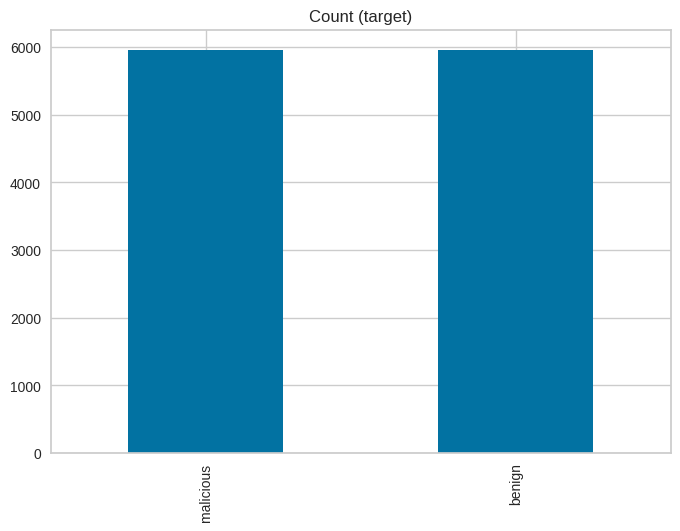

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.classification.value_counts())

df_test_over.classification.value_counts().plot(kind='bar', title='Count (target)');

### Convert non-numeric features to numeric

In [ ]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df

In [ ]:
df = handle_non_numerical_data(df)
print(df.head())

   title_clean  img_count  has_form  has_login_form  has_js  js_include_b64  \
0           97          1         0               0       1               0   
1          245          6         1               1       0               0   
2          722          0         1               1       1               0   
3          579          4         1               1       0               0   
4          581          2         1               1       1               0   

   nb_tokens  text_clean  classification  nb_title_entities  ...  \
0         31        1623               0                0.0  ...   
1          7        1784               0                0.0  ...   
2         19        1501               0                0.0  ...   
3         14        2777               0                0.0  ...   
4         13        2204               0                0.0  ...   

   webmail mini  webmail welcome  went wrong  went wrong dont  would like  \
0             0                0       

In [ ]:
# Split the dataframe into feature and target variables
X = df.drop('classification', axis=1) 
y = df['classification']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Create classifiers

In [ ]:
seed = 1
np.random.seed(seed)

In [ ]:
ab = AdaBoostClassifier(random_state = seed)
et = ExtraTreesClassifier(random_state = seed)
gb = GradientBoostingClassifier(random_state = seed)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state = seed)
rf = RandomForestClassifier(random_state = seed)
rg = RidgeClassifier(random_state = seed)
svc = LinearSVC(random_state = seed)
xgb = xgboost.XGBClassifier()

### AdaBoost Classifier

In [ ]:
model=ab

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 1.0024328231811523
Test accuracy : 90.55%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


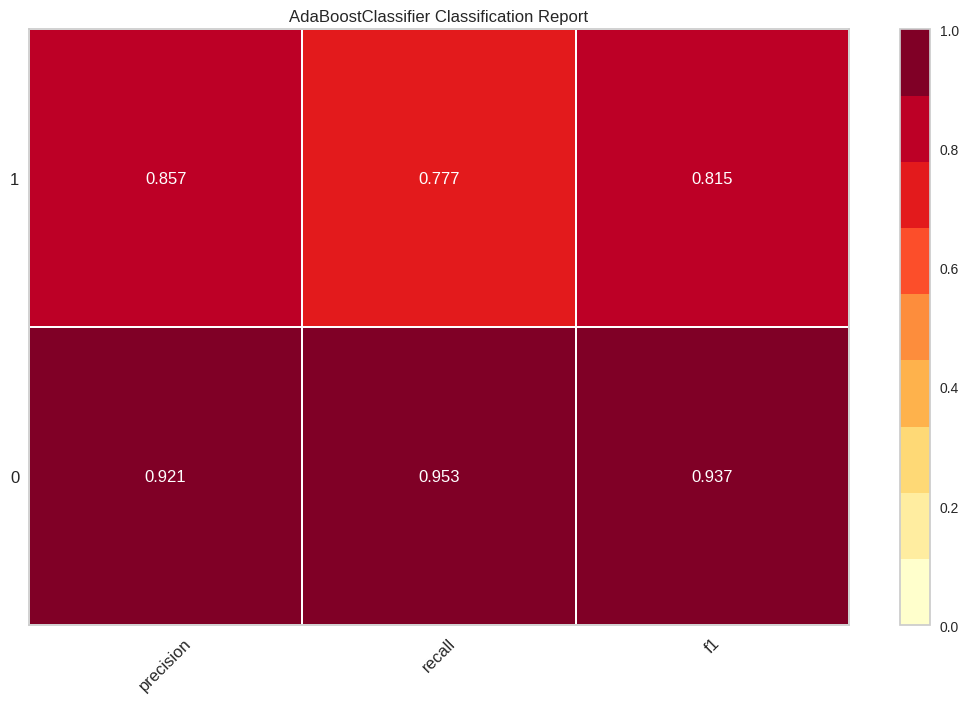

<AxesSubplot: title={'center': 'AdaBoostClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


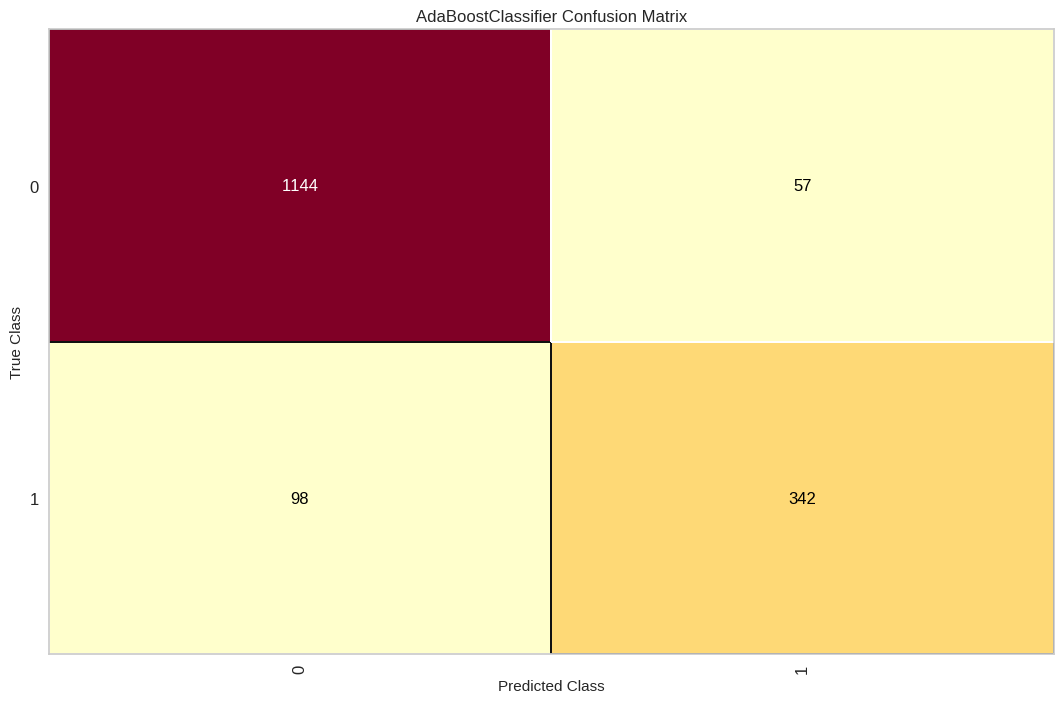

<AxesSubplot: title={'center': 'AdaBoostClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### ExtraTrees Classifier

In [226]:
model=et

In [227]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

# Predict Class Probabilities
y_rf_proba = rf.predict_proba(X_test)
y_rf_pred = np.where(y_rf_proba[:,1] > 0.5, 1, 0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 1.7086353302001953
Test accuracy : 94.82%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


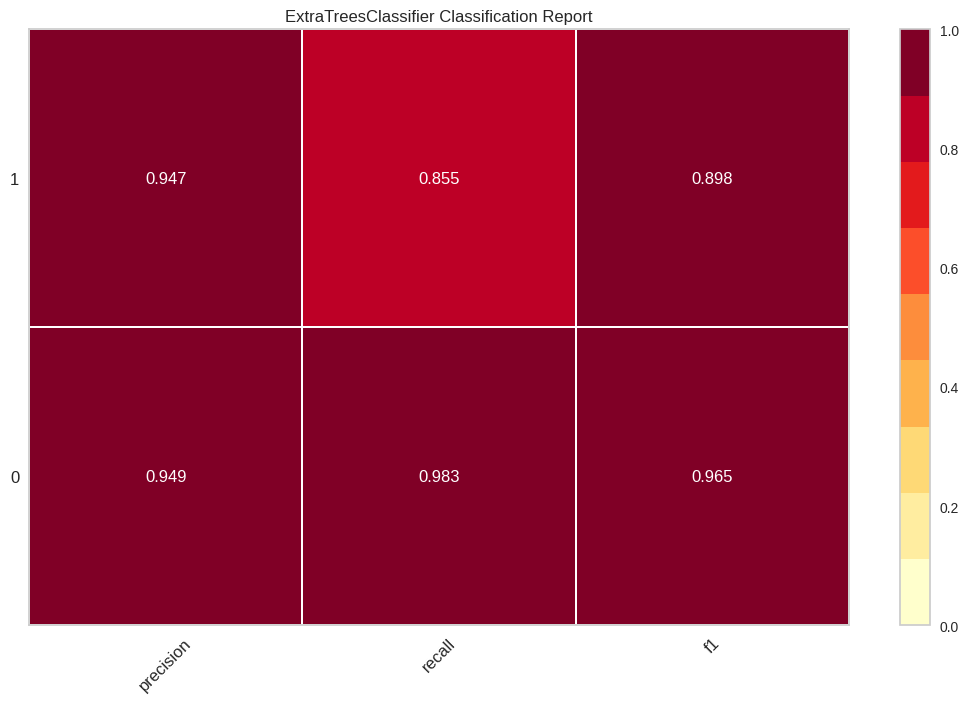

<AxesSubplot: title={'center': 'ExtraTreesClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


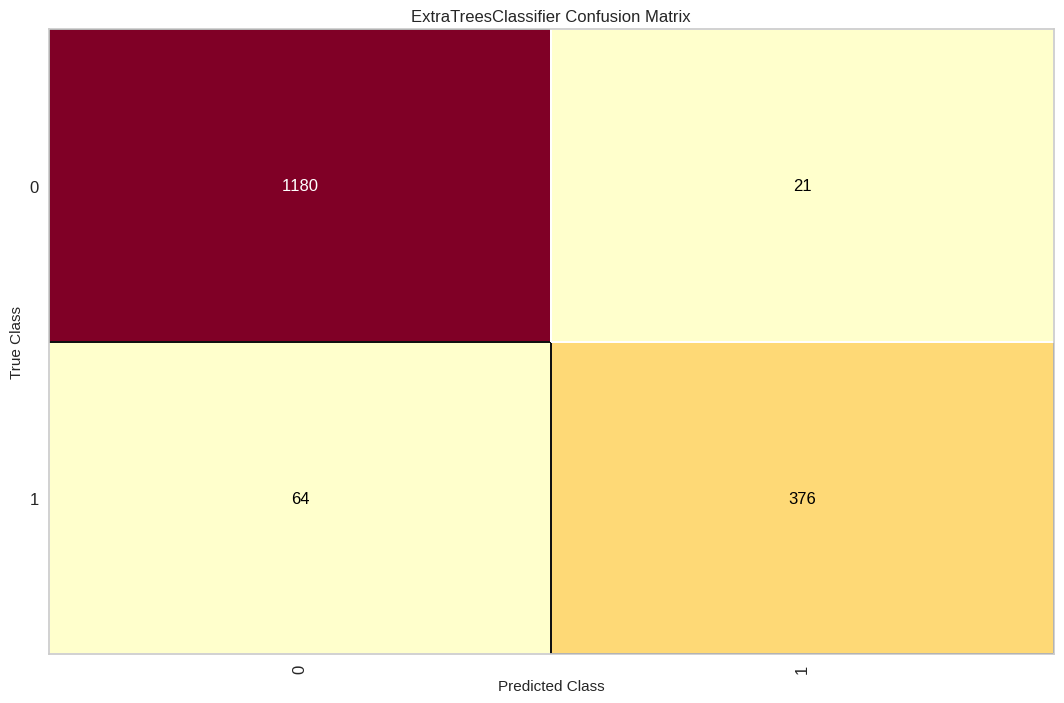

<AxesSubplot: title={'center': 'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


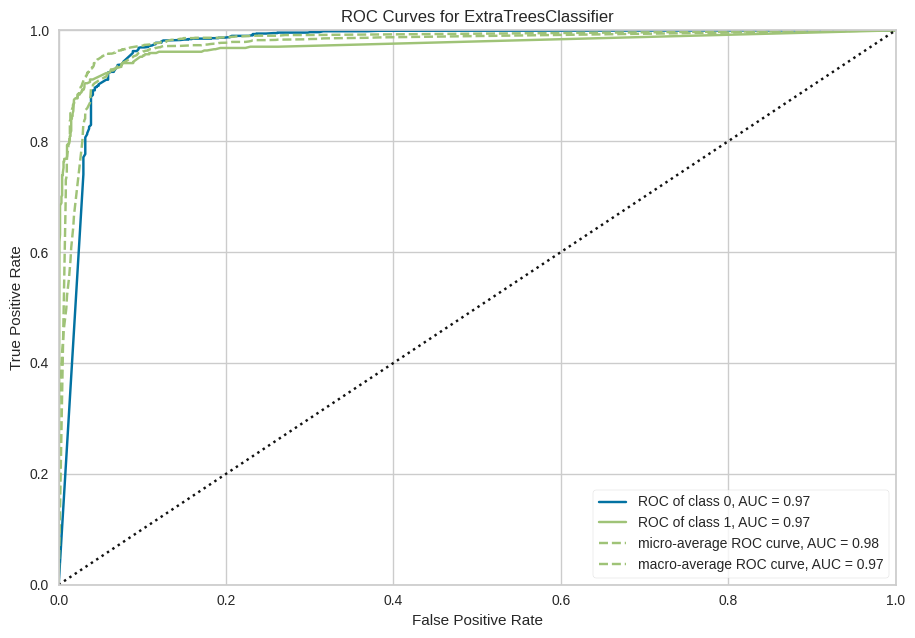

<AxesSubplot: title={'center': 'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [229]:
# Create the visualizer, fit, score, and show it
visualizer = ROCAUC(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)      # Fit the training data to the visualizer
visualizer.score(X_test, y_test)      # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                       # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


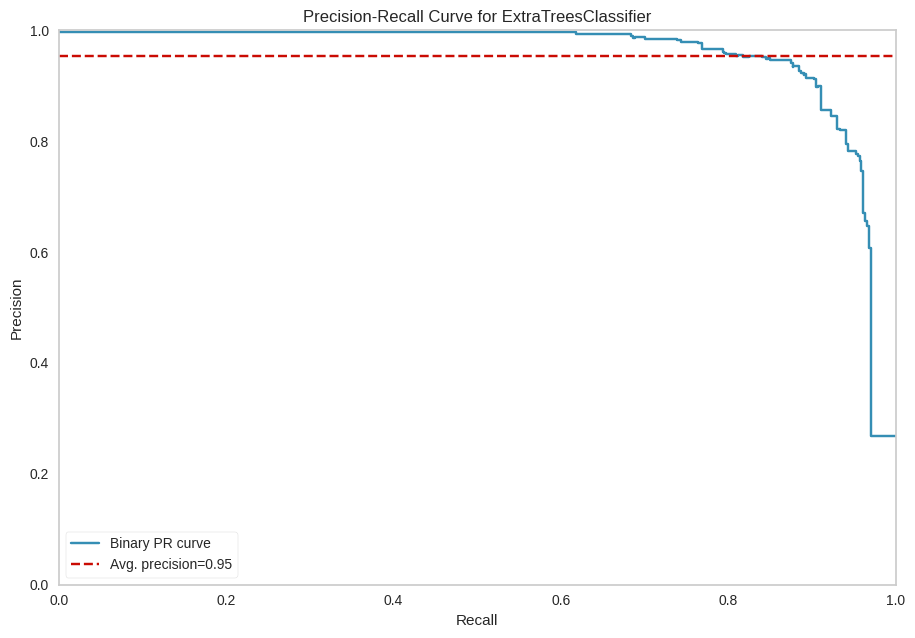

<AxesSubplot: title={'center': 'Precision-Recall Curve for ExtraTreesClassifier'}, xlabel='Recall', ylabel='Precision'>

In [230]:
# Create the visualizer, fit, score, and show it
visualizer = PrecisionRecallCurve(
    model,
    per_class=True,
    cmap="Set1"
)
visualizer.fit(X_train, y_train)    # Fit the training data to the visualizer
visualizer.score(X_test, y_test)    # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                   # Finalize and render the figure

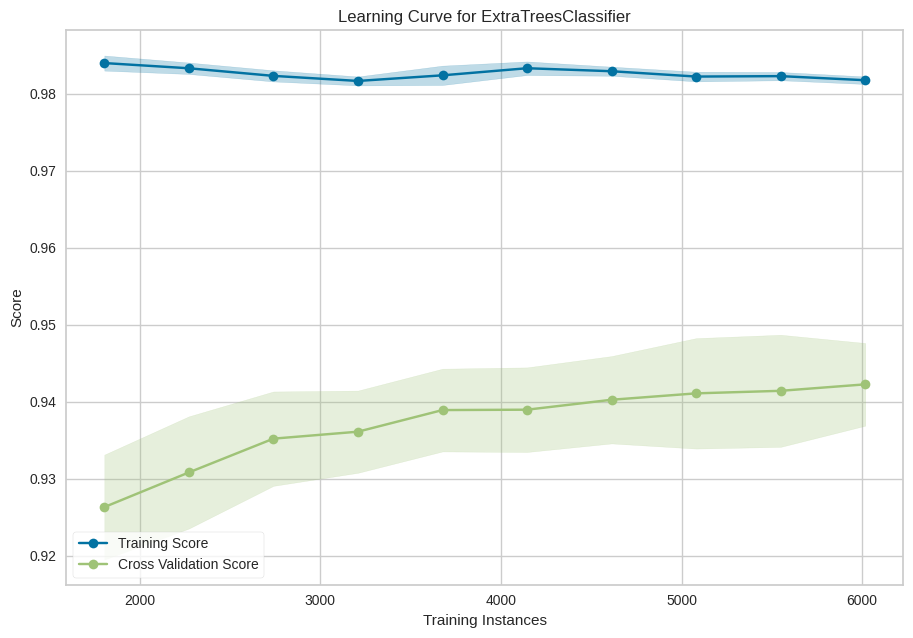

<AxesSubplot: title={'center': 'Learning Curve for ExtraTreesClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [232]:
# Create a cross-validation strategy 
cv = StratifiedKFold(n_splits=12)

# Set the sizes
sizes = np.linspace(0.3, 1.0, 10)

# Create the visualizer, fit and show it
visualizer = LearningCurve(
    model, 
    cv=cv, 
    scoring='f1_weighted', 
    train_sizes=sizes, 
    n_jobs=4
)

visualizer.fit(X_train, y_train)      # Fit the data to the visualizer
visualizer.size=(1080, 720)
visualizer.show()                     # Finalize and render the figure

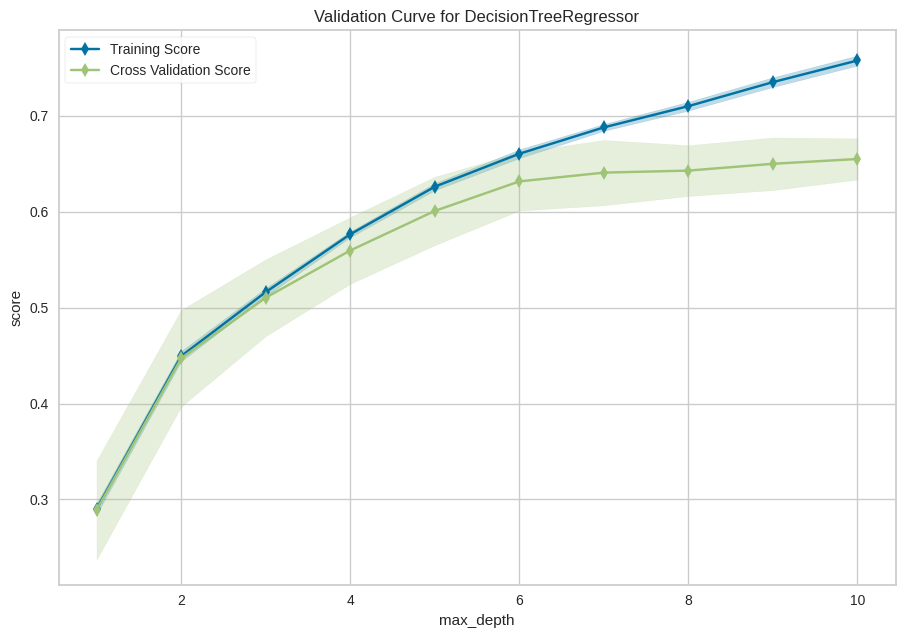

<AxesSubplot: title={'center': 'Validation Curve for DecisionTreeRegressor'}, xlabel='max_depth', ylabel='score'>

In [246]:
visualizer = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

visualizer.fit(X_train, y_train)      # Fit the data to the visualizer
visualizer.size=(1080, 720)
visualizer.show()                     # Finalize and render the figure

#### Cross Validation
Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.

We are using k-fold cross-validation method to perform cross-validation. In k-fold cross-validation, you split the input data into k subsets of data (also known as folds). You train an ML model on all but one (k-1) of the subsets, and then evaluate the model on the subset that was not used for training. This process is repeated k times, with a different subset reserved for evaluation (and excluded from training) each time.

In [234]:
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)

Informally, accuracy is the fraction of predictions our model got right. Formally, accuracy has the following definition: Accuracy = Number of correct predictions Total number of predictions.

In [235]:
# Cross Validation Classification Accuracy
scoring = 'accuracy'
results = model_selection.cross_val_score(et, X, y, cv=kfold, scoring=scoring)
print("Accuracy: %.3f (%.3f)" % (results.mean(), results.std()))

Accuracy: 0.945 (0.007)


Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value.

In [236]:
# Cross Validation Classification LogLoss
scoring = 'neg_log_loss'
results = model_selection.cross_val_score(et, X, y, cv=kfold, scoring=scoring)
print("Logloss: %.3f (%.3f)" % (results.mean(), results.std()))

Logloss: -0.473 (0.101)


AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

In [237]:
# Cross Validation Classification ROC AUC
scoring = 'roc_auc'
results = model_selection.cross_val_score(et, X, y, cv=kfold, scoring=scoring)
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.970 (0.005)


The Mean Squared Error (MSE) is defined as Mean or Average of the square of the difference between actual and estimated values.

In [238]:
# Cross Validation Regression MSE
scoring = 'neg_mean_squared_error'
results = model_selection.cross_val_score(et, X, y, cv=kfold, scoring=scoring)
print("MSE: %.3f (%.3f)" % (results.mean(), results.std()))

MSE: -0.055 (0.007)


R-squared is a statistical measure that represents the goodness of fit of a regression model.

In [239]:
# Cross Validation Regression R-squared
scoring = 'r2'
results = model_selection.cross_val_score(et, X, y, cv=kfold, scoring=scoring)
print("R2: %.3f (%.3f)" % (results.mean(), results.std()))

R2: 0.724 (0.035)


Log Loss how close the prediction probability is to its corresponding value in binary classification. If the predicted probablity diverges far from the actual then the log-loss value is higher.

In [241]:
logloss = log_loss(y_test, rf.predict_proba(X_test))
logloss

0.25991286490189874

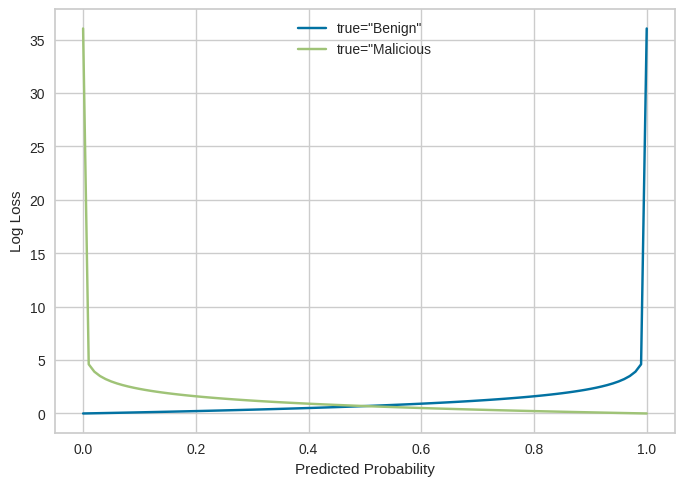

In [242]:
# predictions as 0 to 1 in 0.01 increments
yhat = [x*0.01 for x in range(0, 101)]

# evaluate predictions for a 0 true value
losses_0 = [log_loss([0], [x], labels=[0,1]) for x in yhat]

# evaluate predictions for a 1 true value
losses_1 = [log_loss([1], [x], labels=[0,1]) for x in yhat]

# plot input to loss
plt.plot(yhat, losses_0, label='true="Benign"')
plt.plot(yhat, losses_1, label='true="Malicious')
plt.xlabel('Predicted Probability')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

#### Get feature importance

Summary of Feature Importance:
title_clean: Score: 0.04070
img_count: Score: 0.03550
has_form: Score: 0.03973
has_login_form: Score: 0.16030
has_js: Score: 0.01311
js_include_b64: Score: 0.00200
nb_tokens: Score: 0.04765
text_clean: Score: 0.05454
nb_title_entities: Score: 0.01136
nb_text_entities: Score: 0.02685
bank_of_america: Score: 0.00031
wells_fargo: Score: 0.00082
citibank: Score: 0.00000
apple: Score: 0.00337
microsoft: Score: 0.01014
amazon: Score: 0.00170
google: Score: 0.00354
facebook: Score: 0.00056
dhl: Score: 0.00001
youtube: Score: 0.00000
whatsapp: Score: 0.00002
linkedin: Score: 0.00013
twitter: Score: 0.00474
access account: Score: 0.00296
account account: Score: 0.00083
account account create: Score: 0.00029
account another: Score: 0.00016
account another account: Score: 0.00028
account create: Score: 0.00396
account create one: Score: 0.00110
account doe: Score: 0.00088
account doe n: Score: 0.00093
account enter: Score: 0.00094
account enter password: Score: 0.00

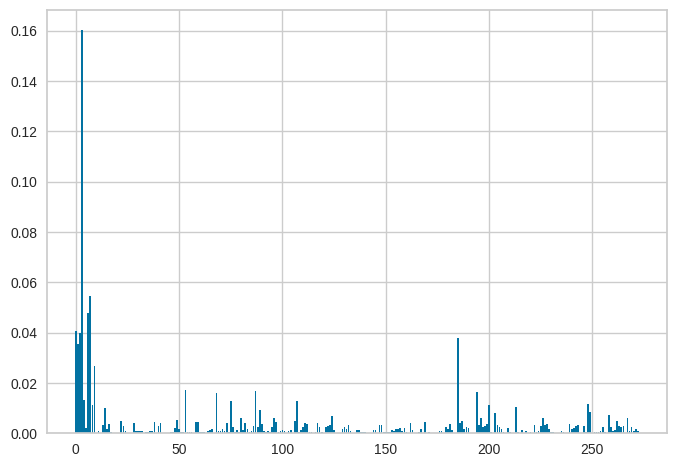

In [243]:
# get importance
importance = et.feature_importances_

# summarize feature importance
print('Summary of Feature Importance:')
for i,v in enumerate(importance):
 print(et.feature_names_in_[i] + ': Score: %.5f' % (v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Hyperparameter Tuning

In [206]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [208]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
etr = ExtraTreesRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
et_random = RandomizedSearchCV(
    estimator=etr, 
    param_distributions=random_grid, 
    n_iter=100, 
    cv=3, 
    verbose=2, 
    random_state=1, 
    n_jobs=-1
)

# Fit the random search model
et_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [209]:
et_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [210]:
et_tr = ExtraTreesClassifier(
    n_estimators=400,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=100,
    bootstrap=False
)

In [211]:
model=et_tr

In [212]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 5.516924142837524
Test accuracy : 94.52%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


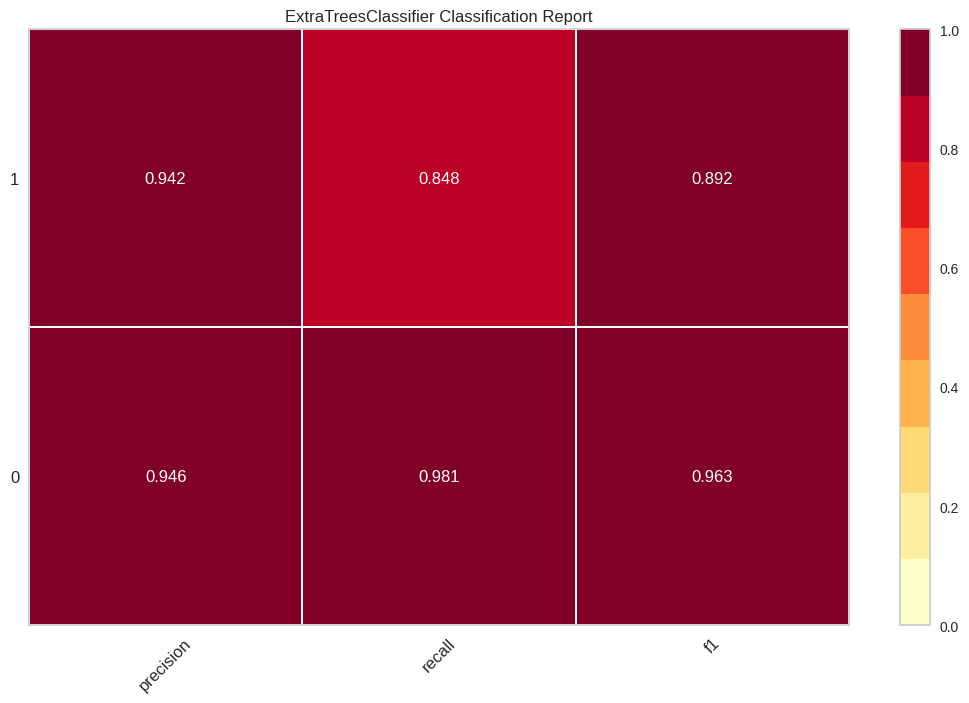

<AxesSubplot: title={'center': 'ExtraTreesClassifier Classification Report'}>

In [213]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


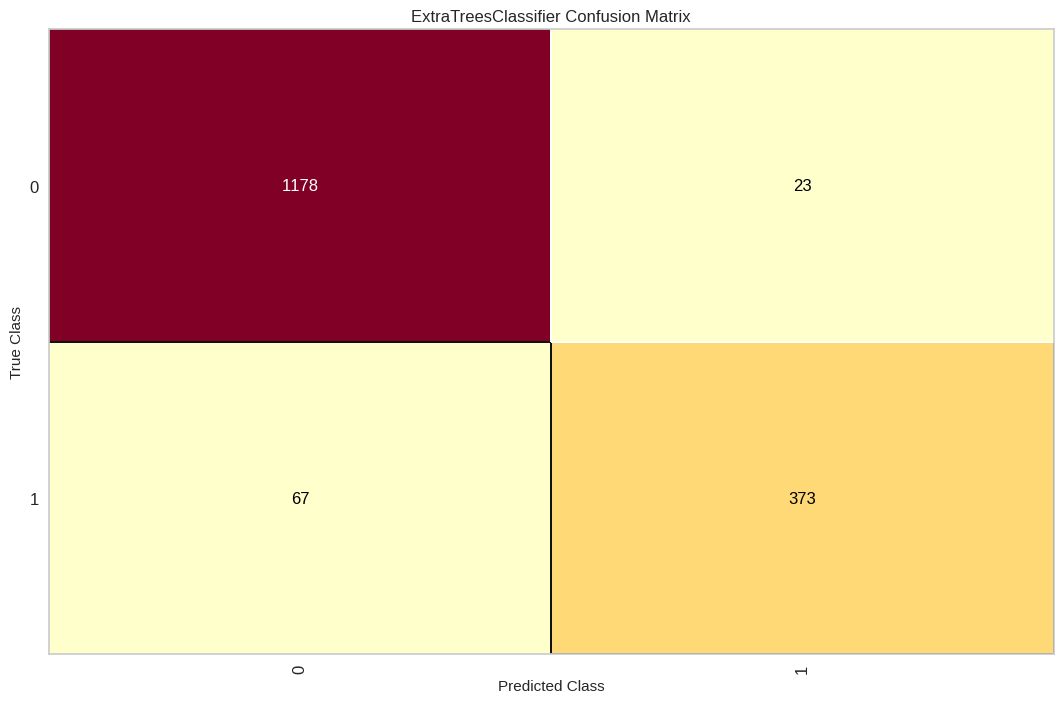

<AxesSubplot: title={'center': 'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [214]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### GradientBoosting Classifier

In [ ]:
model=gb

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 3.003483295440674
Test accuracy : 91.83%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


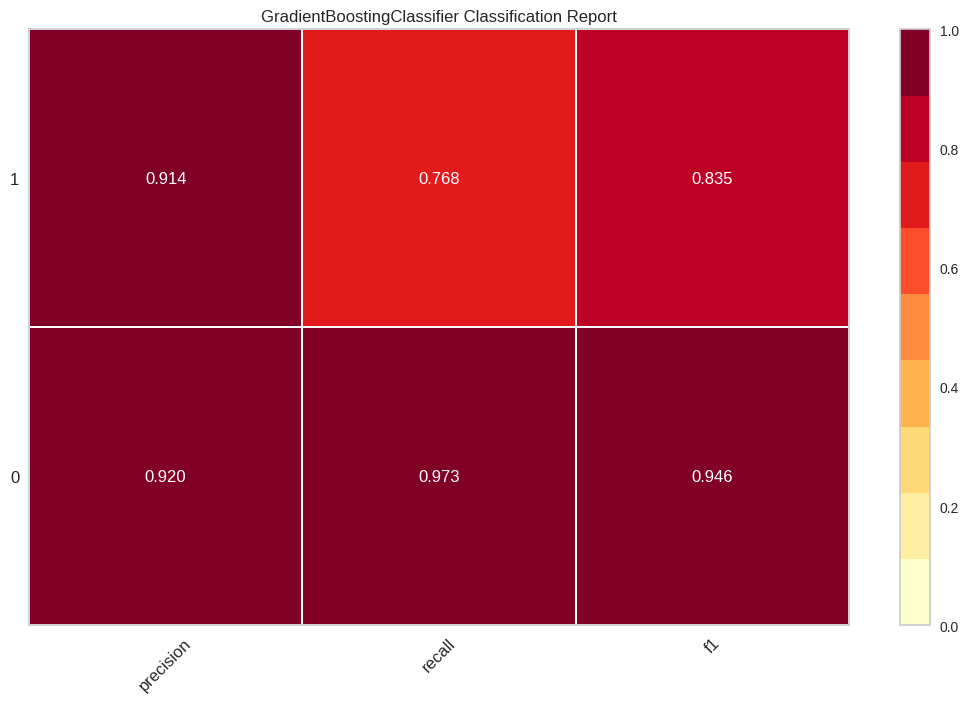

<AxesSubplot: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


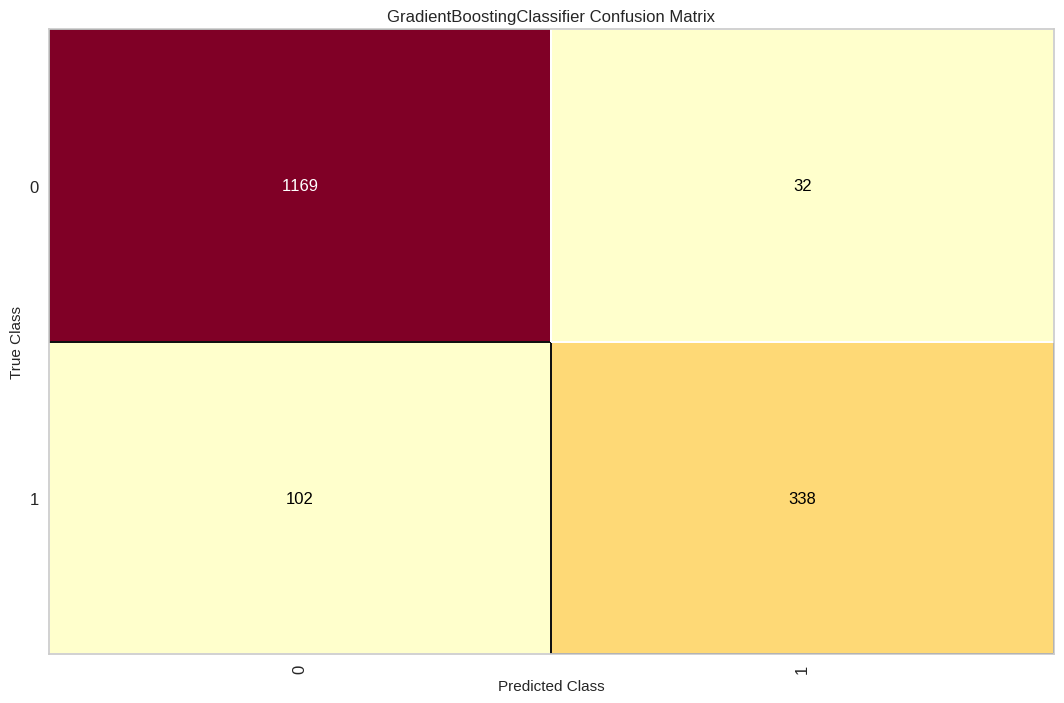

<AxesSubplot: title={'center': 'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### K-Nearest Neighbors Classifier

In [ ]:
model=knn

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 0.019719362258911133
Test accuracy : 85.56%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


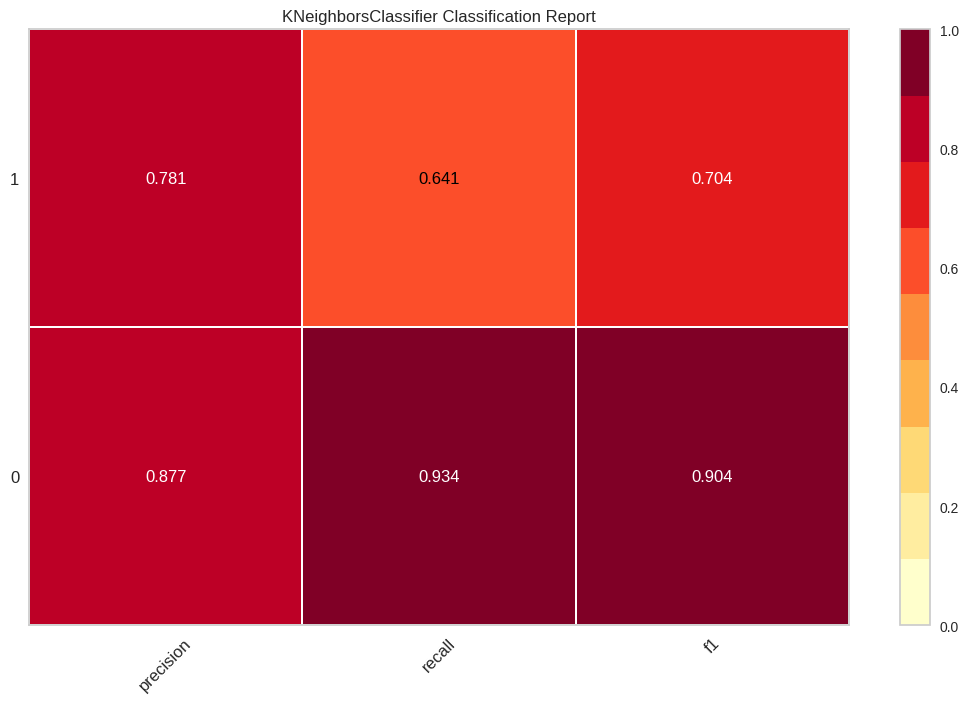

<AxesSubplot: title={'center': 'KNeighborsClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


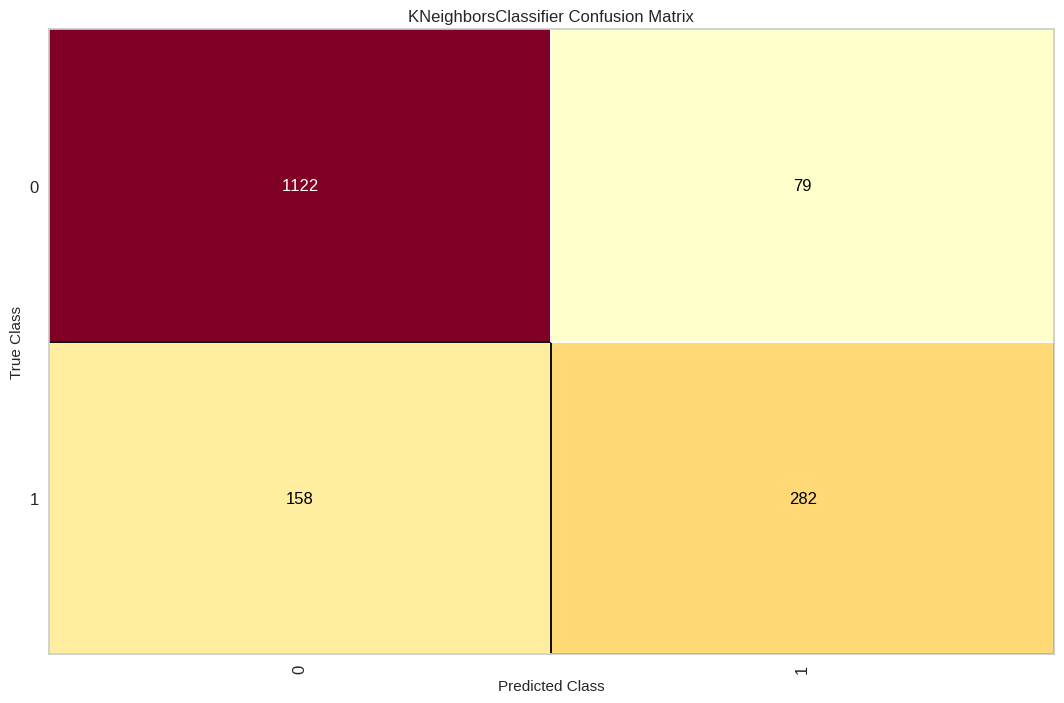

<AxesSubplot: title={'center': 'KNeighborsClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### Logistic Regression Classifier

In [ ]:
model=lr

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))


Training time: 0.2789921760559082
Test accuracy : 86.29%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


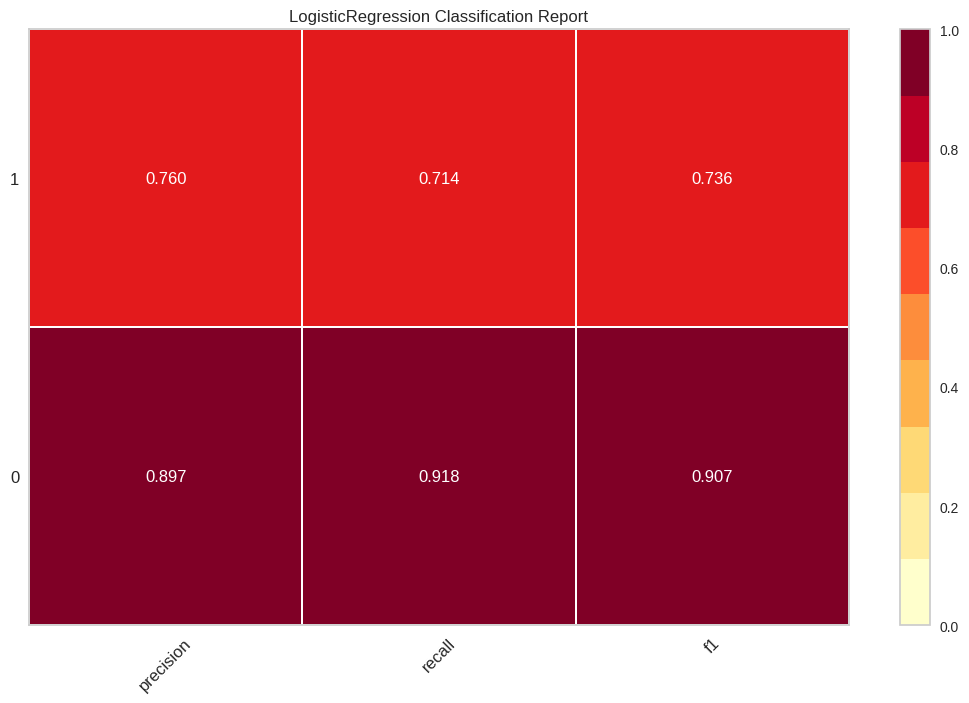

<AxesSubplot: title={'center': 'LogisticRegression Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


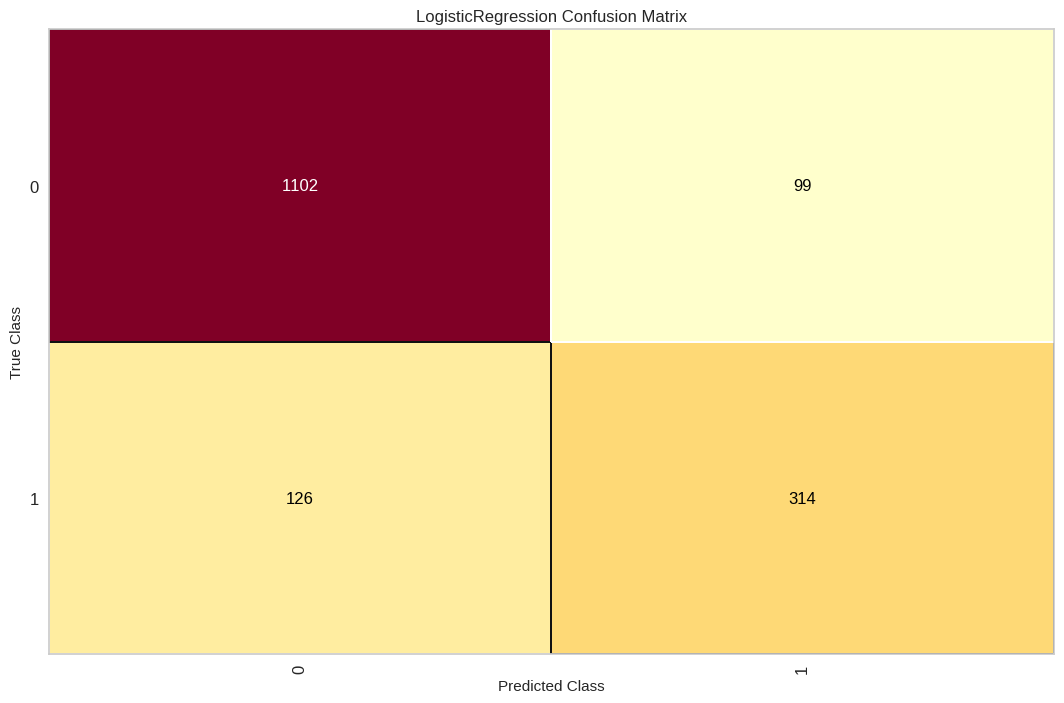

<AxesSubplot: title={'center': 'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### LinearSVC Classifier

In [ ]:
model=svc

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 0.7756800651550293
Test accuracy : 80.93%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


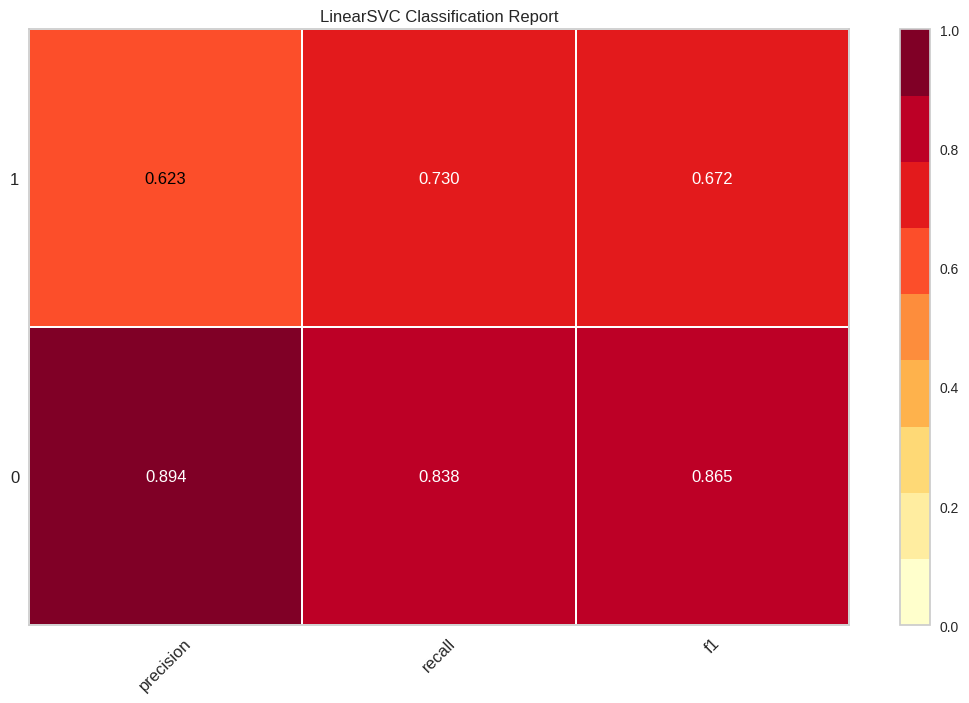

<AxesSubplot: title={'center': 'LinearSVC Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


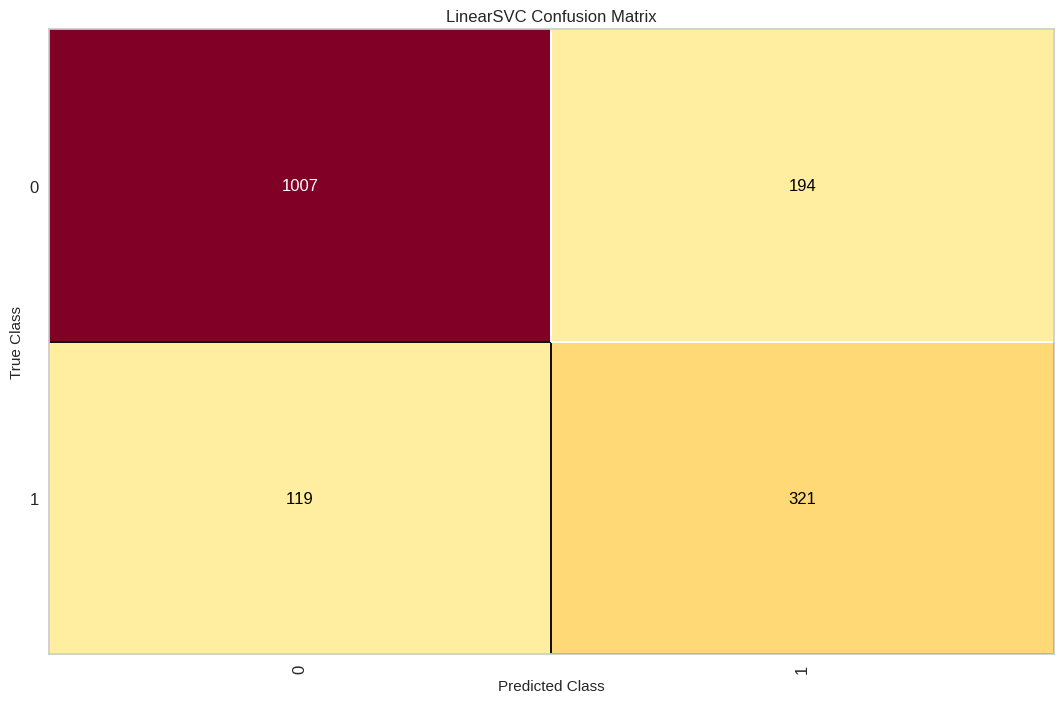

<AxesSubplot: title={'center': 'LinearSVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### Random Forest Classifier

In [ ]:
model=rf

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 1.2509922981262207
Test accuracy : 94.58%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


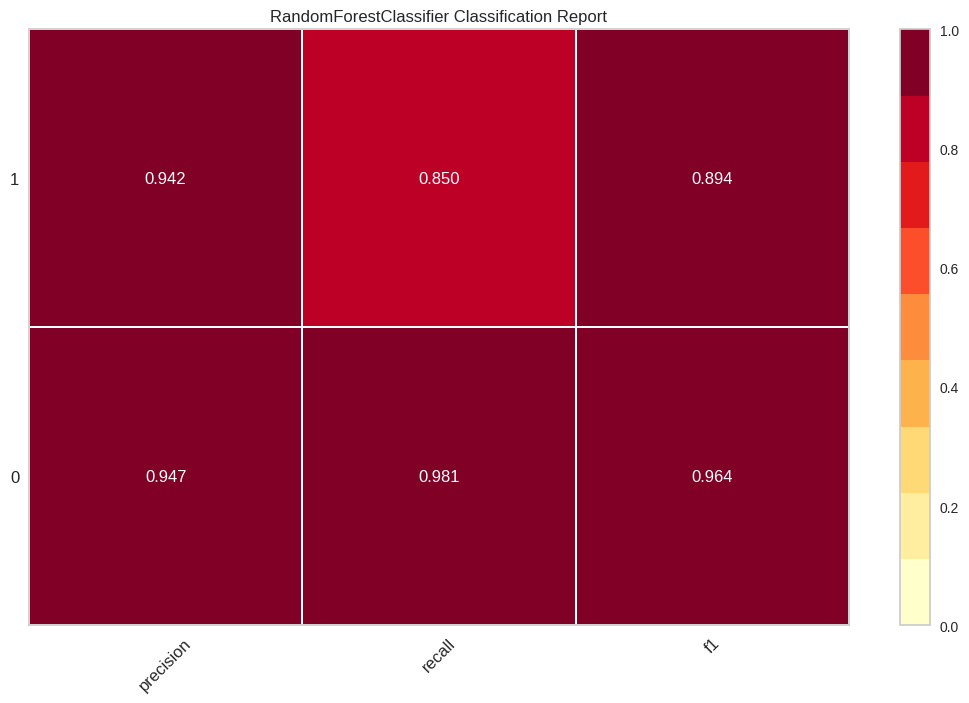

<AxesSubplot: title={'center': 'RandomForestClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


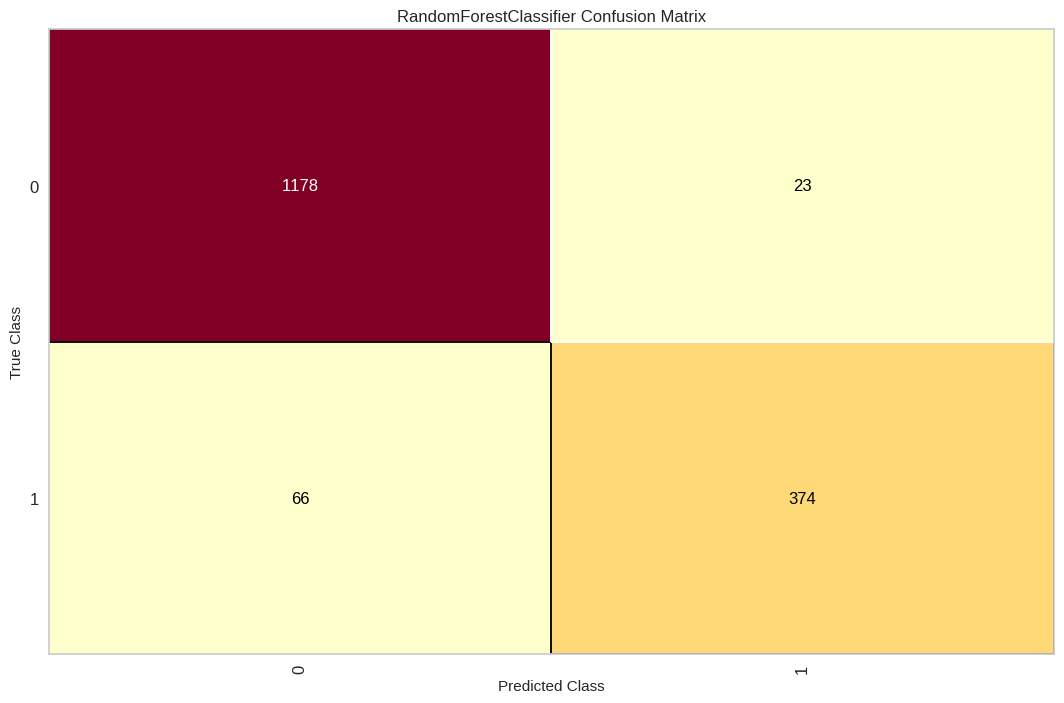

<AxesSubplot: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### Ridge Regression Classifier

In [ ]:
model=rg

In [ ]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 0.09974074363708496
Test accuracy : 90.01%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


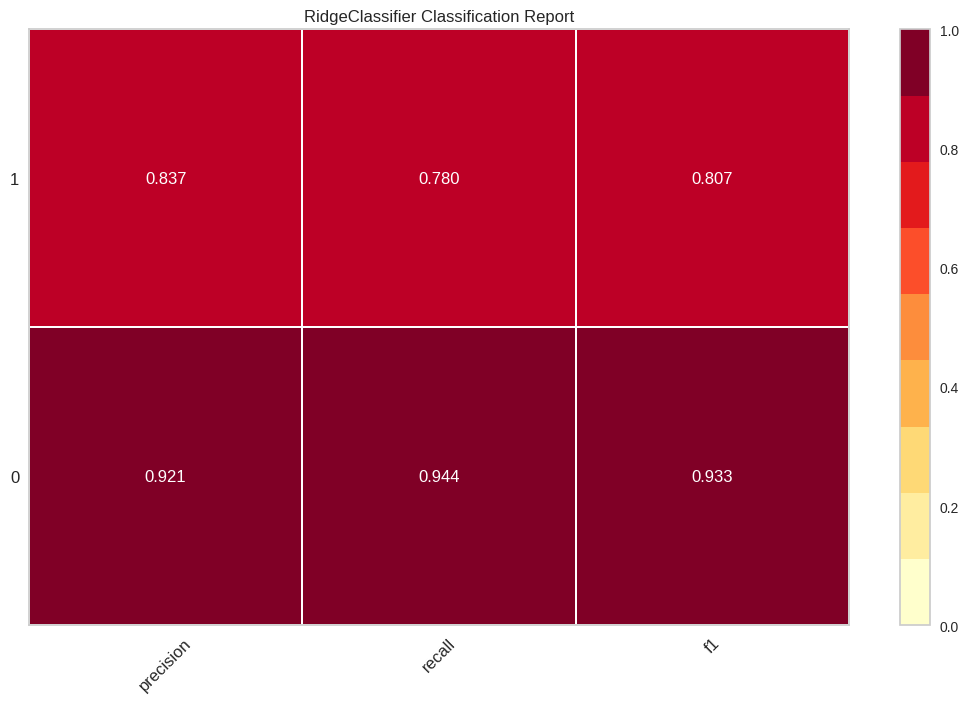

<AxesSubplot: title={'center': 'RidgeClassifier Classification Report'}>

In [ ]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RidgeClassifier was fitted with feature names
  warnings.warn(


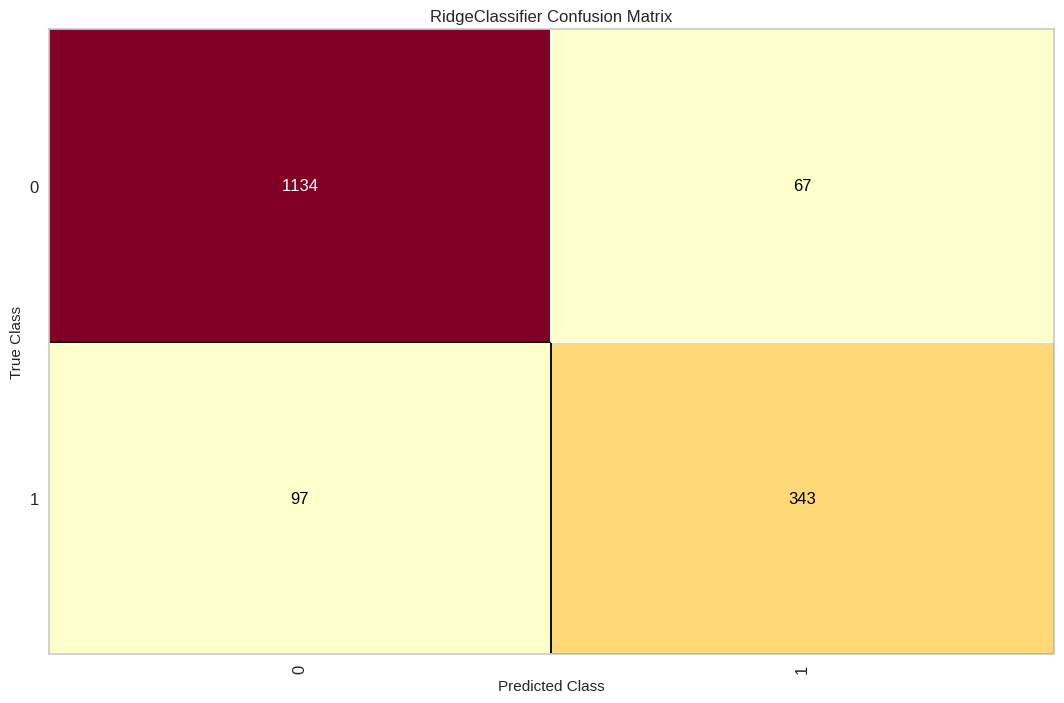

<AxesSubplot: title={'center': 'RidgeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### XGBoost Classifier

In [187]:
model=xgb

In [188]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 9.456074476242065
Test accuracy : 94.27%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


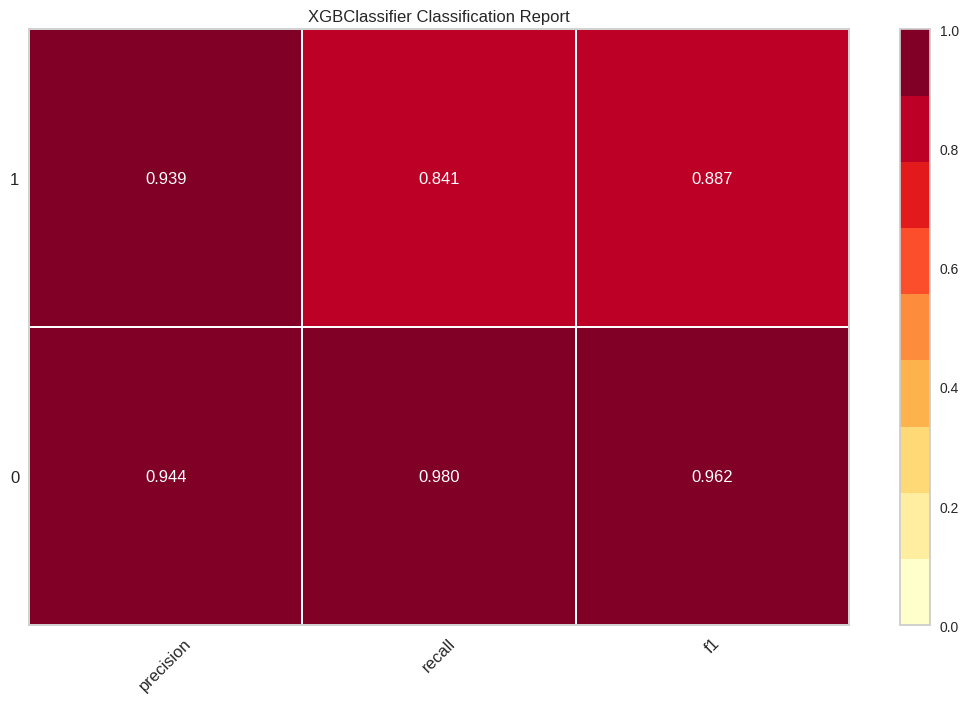

<AxesSubplot: title={'center': 'XGBClassifier Classification Report'}>

In [189]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

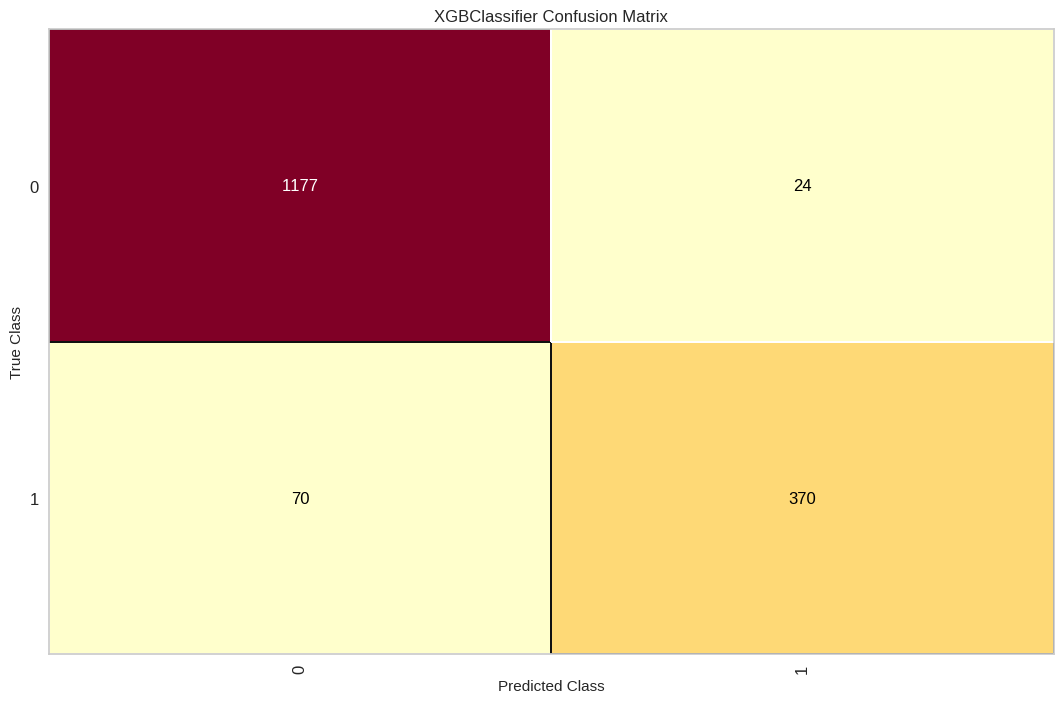

<AxesSubplot: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [190]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

## Ensemble Learning

### Bagging

In [166]:
clf_array = [rf, et, knn, svc, rg]

for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, n_jobs=-1)
    
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__, vanilla_scores.mean(), vanilla_scores.std()))
    print("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__, bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.947, std: (+/-) 0.006 [RandomForestClassifier]
Mean of: 0.754, std: (+/-) 0.004 [Bagging RandomForestClassifier]

Mean of: 0.944, std: (+/-) 0.005 [ExtraTreesClassifier]
Mean of: 0.754, std: (+/-) 0.004 [Bagging ExtraTreesClassifier]

Mean of: 0.859, std: (+/-) 0.012 [KNeighborsClassifier]
Mean of: 0.754, std: (+/-) 0.004 [Bagging KNeighborsClassifier]

Mean of: 0.741, std: (+/-) 0.154 [LinearSVC]
Mean of: 0.726, std: (+/-) 0.000 [Bagging LinearSVC]

Mean of: 0.898, std: (+/-) 0.008 [RidgeClassifier]
Mean of: 0.726, std: (+/-) 0.000 [Bagging RidgeClassifier]



### Set up voting

In [167]:
eclf = VotingClassifier(estimators=[('Random Forests', rf), 
                                    ('Extra Trees', et), 
                                    ('Ridge Classifier', rg)], 
                         voting='hard')

for clf, label in zip([rf, et, rg, eclf], ['Random Forest', 'Extra Trees', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.947, std: (+/-) 0.006 [Random Forest]
Mean: 0.944, std: (+/-) 0.005 [Extra Trees]
Mean: 0.898, std: (+/-) 0.008 [Ridge Classifier]
Mean: 0.946, std: (+/-) 0.006 [Ensemble]


### Set up ensemble voting for bagging

In [168]:
ebclf_array = []

for clf in clf_array:
    ebclf_array.append(BaggingClassifier(clf, max_samples=0.25, max_features=10, random_state=seed))

v_eclf = VotingClassifier(estimators=[('Bagging Random Forest', BaggingClassifier(rf, max_samples=0.25, max_features=10, random_state=seed)), 
                                      ('Bagging Extra Trees', BaggingClassifier(et, max_samples=0.25, max_features=10, random_state=seed)), 
                                      ('Bagging Ridge Classifier', BaggingClassifier(rg, max_samples=0.25, max_features=10, random_state=seed))], 
                         voting='hard')

ebclf_array.append(v_eclf)

for clf, label in zip(ebclf_array, ['Bagging Random Forest', 
                                    'Bagging Extra Trees', 
                                    'Bagging Ridge Classifier', 
                                    'Bagging Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.755, std: (+/-) 0.005 [Bagging Random Forest]
Mean: 0.755, std: (+/-) 0.005 [Bagging Extra Trees]
Mean: 0.754, std: (+/-) 0.004 [Bagging Ridge Classifier]
Mean: 0.726, std: (+/-) 0.000 [Bagging Ensemble]


In [169]:
model=v_eclf

In [170]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 5.310471534729004
Test accuracy : 75.50%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


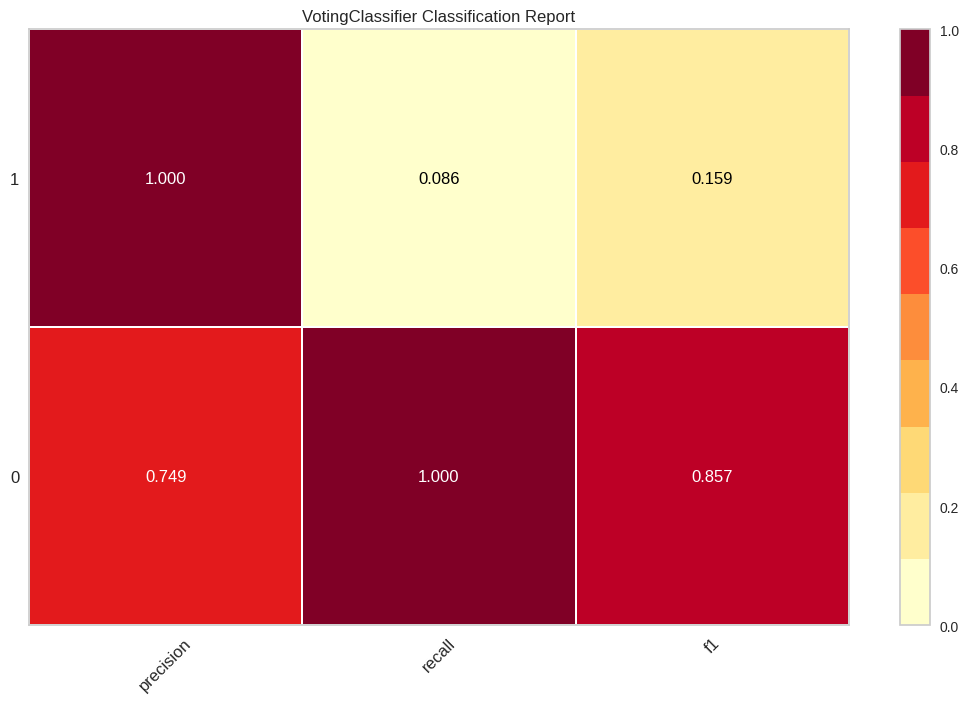

<AxesSubplot: title={'center': 'VotingClassifier Classification Report'}>

In [171]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


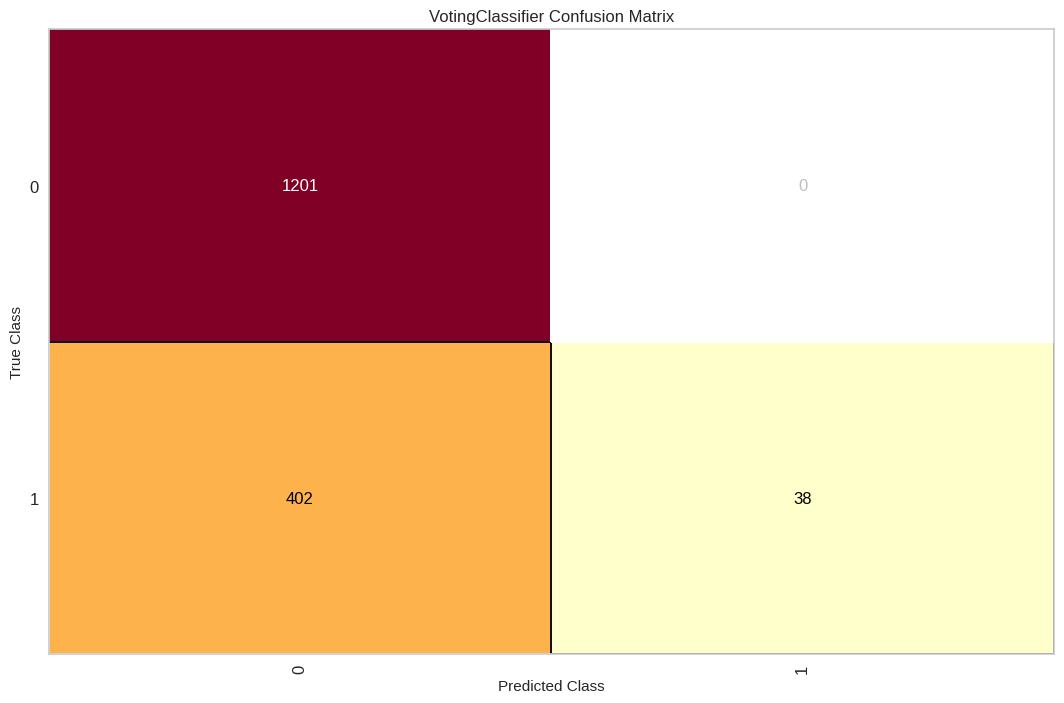

<AxesSubplot: title={'center': 'VotingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [172]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)       # Fit the training data to the visualizer
visualizer.score(X_test, y_test)       # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                      # Finalize and render the figure

### Boosting

In [191]:
boost_array = [ab, gb, xgb]

eclf = EnsembleVoteClassifier(clfs=[ab, gb, xgb], voting='hard')

labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ab, gb, xgb, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.904, std: (+/-) 0.006 [Ada Boost]
Mean: 0.919, std: (+/-) 0.008 [Grad Boost]
Mean: 0.942, std: (+/-) 0.005 [XG Boost]
Mean: 0.921, std: (+/-) 0.006 [Ensemble]


In [192]:
model=eclf

In [193]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 7.657255172729492
Test accuracy : 92.02%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


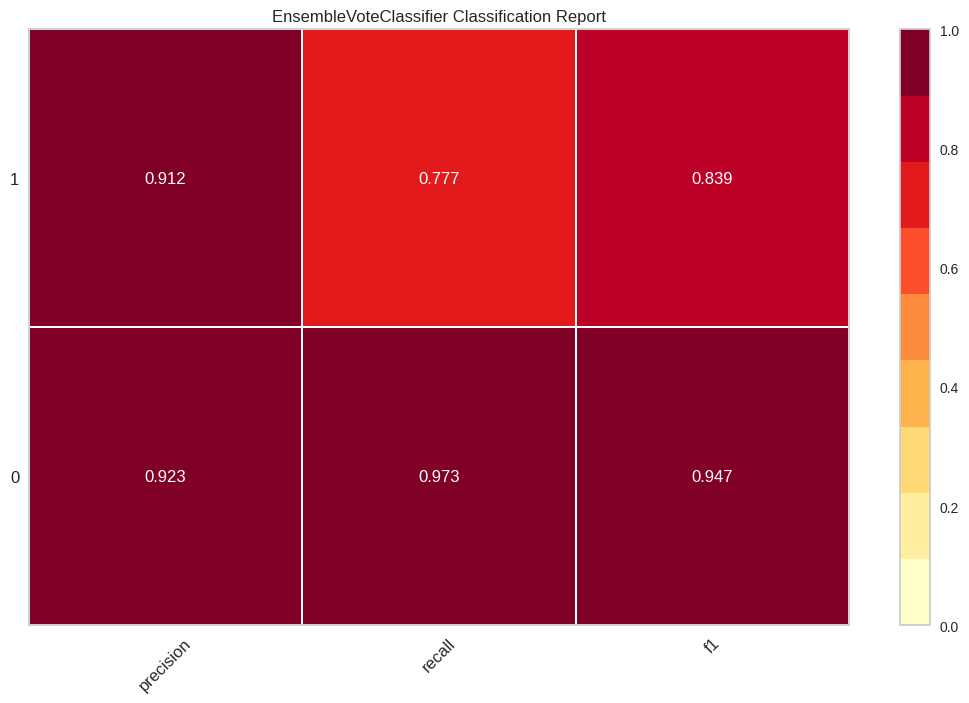

<AxesSubplot: title={'center': 'EnsembleVoteClassifier Classification Report'}>

In [194]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


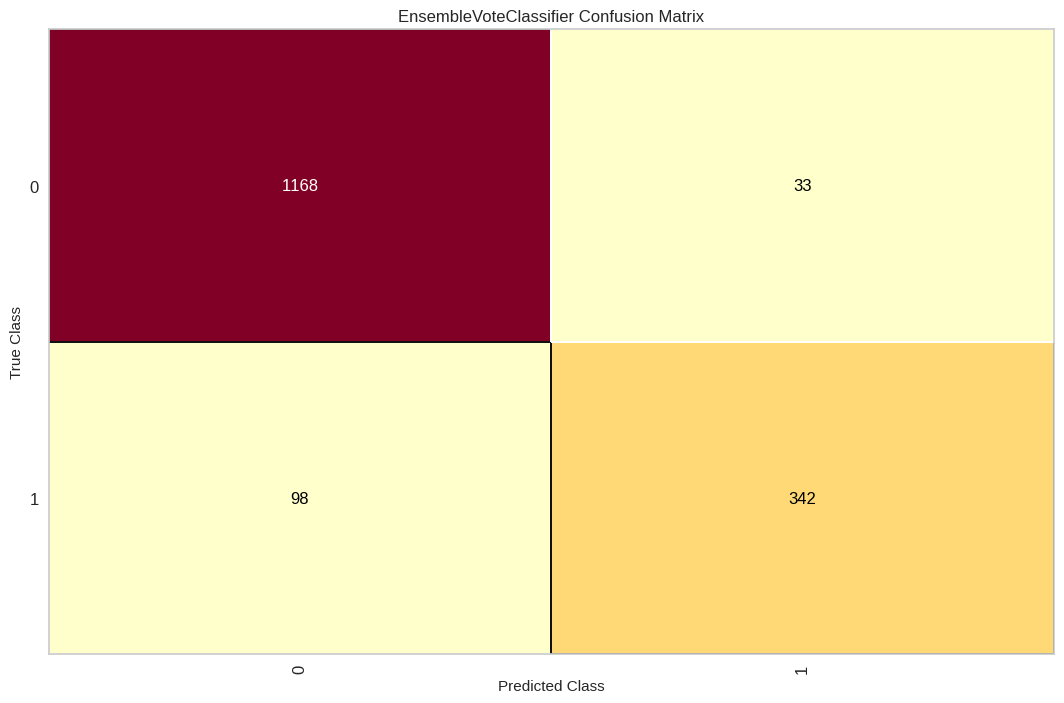

<AxesSubplot: title={'center': 'EnsembleVoteClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [195]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

### Stacking

In [201]:
estimators = [
  ('et', et),
  ('rf', rf),
  ('xgb', xgb)
]

s_eclf = StackingClassifier(
  estimators=estimators, 
  final_estimator=et
)

s_eclf.fit(X_train, y_train)

StackingClassifier(estimators=[('et', ExtraTreesClassifier(random_state=1)),
                               ('rf', RandomForestClassifier(random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=Non...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   final_estimator=ExtraTreesClassifier(random_state=1))

In [202]:
model=s_eclf

In [203]:
# Train the model
t0 = time.time()
model.fit(X_train, y_train)
print("Training time:", time.time() - t0)

y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print('Test accuracy : {:.2f}%'.format(score * 100))

Training time: 38.10980796813965
Test accuracy : 93.30%


/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


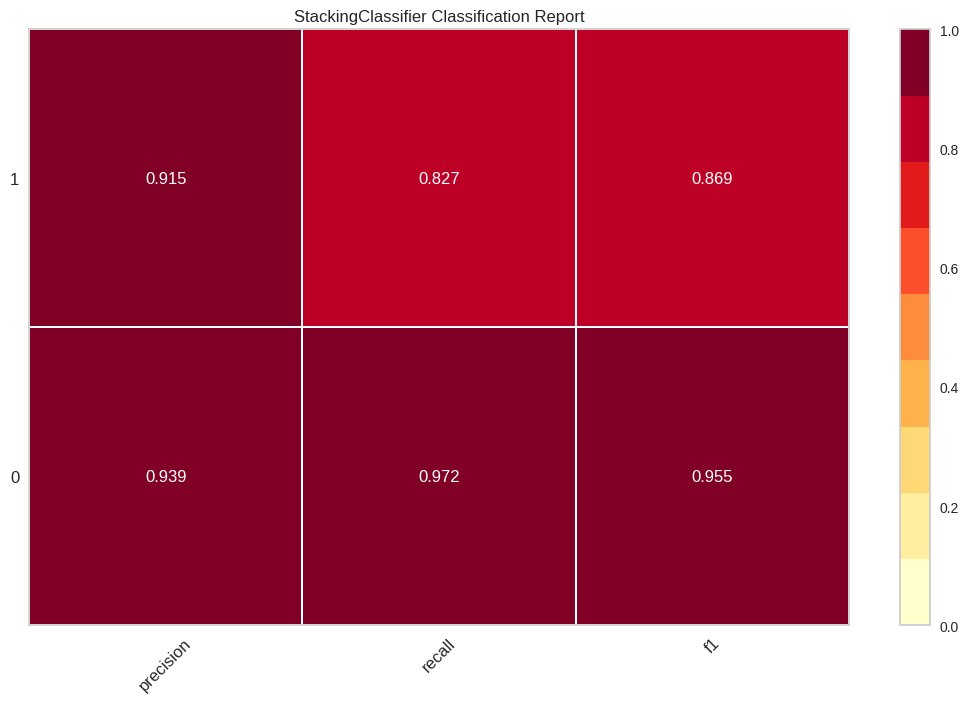

<AxesSubplot: title={'center': 'StackingClassifier Classification Report'}>

In [204]:
# Create the visualizer, score and show it
visualizer = ClassificationReport(model)
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


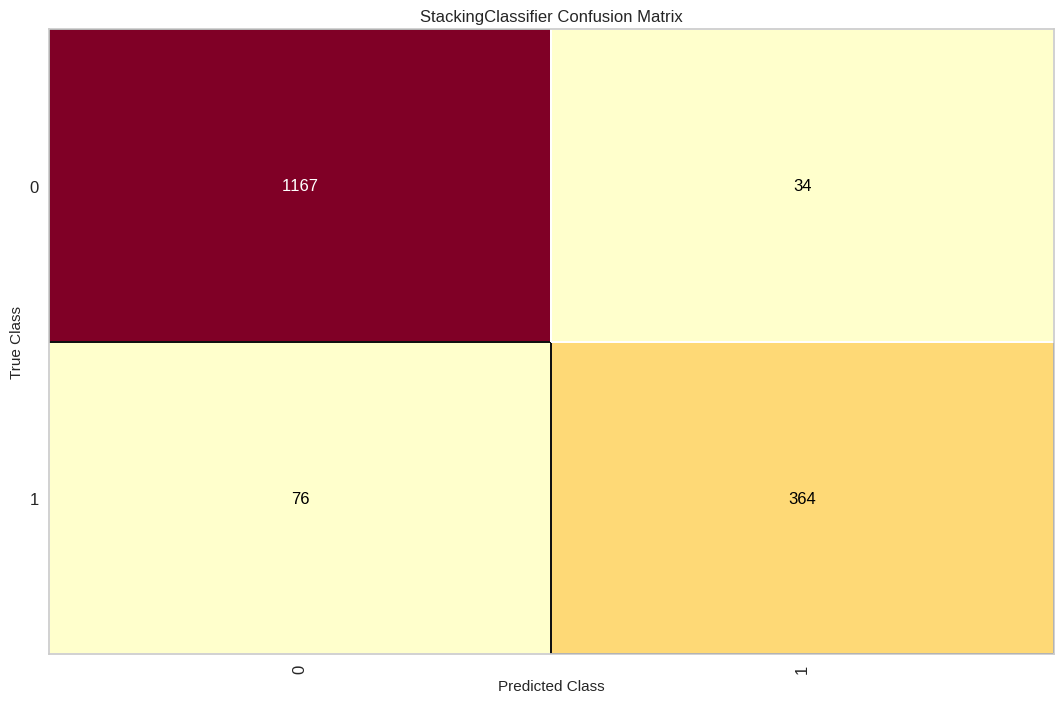

<AxesSubplot: title={'center': 'StackingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [205]:
# Create the visualizer, fit, score, and show it
visualizer = ConfusionMatrix(
    model, 
    classes=model.classes_
)

visualizer.fit(X_train, y_train)     # Fit the training data to the visualizer
visualizer.score(X_test, y_test)     # Evaluate the model on the test data
visualizer.size=(1080, 720)
visualizer.show()                    # Finalize and render the figure